# Disaggregate PES-level demand data to GSP

**Jamie Taylor**

**2022-01-20**

## Setup

In [1]:
import sys
import gc
from copy import copy
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.metrics import RootMeanSquaredError
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

sys.path.append("../")
from load_data import DataLoader
from utilities import expand_1hot_cols, prepare_xy, encode_cyclical_cols, \
    train_test_split_by_col, normalise_cols, unnormalise_cols, remove_anomalous_gsps

2022-08-30 13:33:19.828632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-30 13:33:19.828740: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
%matplotlib inline
sns.set(style="darkgrid")
plt.rcParams['figure.dpi'] = 150
np.random.seed(42)

## Load the training data

In [3]:
loader = DataLoader(data_dir="/mnt/sheffield_solar_2/SheffieldSolar_RSE/training_data_20220218",
                    cache_dir="/mnt/sheffield_solar_2/SheffieldSolar_RSE/cache/jamie")
pes_gsp_data, gsp_msoa_data = loader.load_data()

[load_data.py] Loading combined data from cache...
[load_data.py]     -> Done (152.3 seconds)


In [4]:
pes_gsp_data.head()

region_id_20210423                 timestamp  pes_id pes_name  \
0                   9 2014-01-01 00:30:00+00:00      20       _H   
1                   9 2014-01-01 01:00:00+00:00      20       _H   
2                   9 2014-01-01 01:30:00+00:00      20       _H   
3                   9 2014-01-01 02:00:00+00:00      20       _H   
4                   9 2014-01-01 02:30:00+00:00      20       _H   

   gsp_meter_volume  pes_meter_volume  pv_yield_mw_per_mwp  \
0             40.70         1747.9728                  0.0   
1             41.38         1780.9923                  0.0   
2             40.12         1735.3562                  0.0   
3             38.20         1653.6627                  0.0   
4             36.62         1574.1164                  0.0   

   pv_cumul_instcap_mwp  mean_building_area  mean_address_area  ...  \
0              12.43989            234.7107           163.0276  ...   
1              12.43989            234.7107           163.0276  ...   
2              12.43989            234.7107           163.0276  ...   
3              12.43989            234.7107           163.0276  ...   
4              12.43989            234.7107           163.0276  ...   

   proportion_mosaic_uk_7_group_d  proportion_mosaic_uk_7_group_c  \
0                          0.0117                          0.0404   
1                          0.0117                          0.0404   
2                          0.0117                          0.0404   
3                          0.0117                          0.0404   
4                          0.0117                          0.0404   

   proportion_mosaic_uk_7_group_u  proportion_mosaic_uk_7_group_unkown  \
0                             0.0                                  0.0   
1                             0.0                                  0.0   
2                             0.0                                  0.0   
3                             0.0                                  0.0   
4                             0.0                                  0.0   

   bank_holiday  gsp_region_area  time_of_day  hour_of_day  weekday  month  
0          True     2.260733e+08     00:30:00          0.5     True      1  
1          True     2.260733e+08     01:00:00          1.0     True      1  
2          True     2.260733e+08     01:30:00          1.5     True      1  
3          True     2.260733e+08     02:00:00          2.0     True      1  
4          True     2.260733e+08     02:30:00          2.5     True      1  

[5 rows x 91 columns]

In [5]:
pes_gsp_data.columns

Index(['region_id_20210423', 'timestamp', 'pes_id', 'pes_name',
       'gsp_meter_volume', 'pes_meter_volume', 'pv_yield_mw_per_mwp',
       'pv_cumul_instcap_mwp', 'mean_building_area', 'mean_address_area',
       'mean_gross_area', 'mean_bathroom_count', 'mean_bedroom_count',
       'mean_reception_room_count', 'mean_extension_count', 'n_uprn_geomni',
       'n_premises', 'proportion_premise_use_warehousing_with_office',
       'proportion_premise_use_health',
       'proportion_premise_use_retail_under_office',
       'proportion_premise_use_under_construction',
       'proportion_premise_use_unclassified',
       'proportion_premise_use_educational',
       'proportion_premise_use_institutional_accommodation',
       'proportion_premise_use_defence', 'proportion_premise_use_transport',
       'proportion_premise_use_office_under_retail',
       'proportion_premise_use_petrol_station',
       'proportion_premise_use_residential_with_retail_below',
       'proportion_premise_use_util

## Prepare training data

Remove any regions with negative demand since they represent high embedded generation.
Also remove any regions where the GSP demand correlates poorly with the PES demand, since we do not expecte these to model well and they impact on the model training.

In [6]:
pes_gsp_data["pv_generation_mw"] = pes_gsp_data["pv_cumul_instcap_mwp"] * pes_gsp_data["pv_yield_mw_per_mwp"]
pes_gsp_data, n, c = remove_anomalous_gsps(pes_gsp_data, threshold_p=0.7)
print(f"{n} GSPs removed due to negative flows")
print(f"{c} GSPs removed due poor correlation with PES demand")
print(f"{n+c} GSPs removed in total")
print(f"{len(pes_gsp_data.region_id_20210423.unique())} GSPs remain")

138 GSPs removed due to negative flows
31 GSPs removed due poor correlation with PES demand
169 GSPs removed in total
136 GSPs remain


RegionID 120... Linear fit: y = 0.04x + 0.90 (r-squared: 0.842)
RegionID 70... Linear fit: y = 0.04x + -5.88 (r-squared: 0.695)
RegionID 91... Linear fit: y = 0.06x + 6.07 (r-squared: 0.855)
RegionID 67... Linear fit: y = 0.09x + 3.69 (r-squared: 0.852)
RegionID 227... Linear fit: y = 0.01x + 9.15 (r-squared: 0.522)
RegionID 98... Linear fit: y = 0.09x + -12.89 (r-squared: 0.930)
RegionID 28... Linear fit: y = 0.07x + 9.51 (r-squared: 0.872)
RegionID 126... Linear fit: y = 0.08x + 14.07 (r-squared: 0.783)
RegionID 22... Linear fit: y = 0.10x + 0.13 (r-squared: 0.734)
RegionID 93... Linear fit: y = 0.02x + 2.22 (r-squared: 0.764)


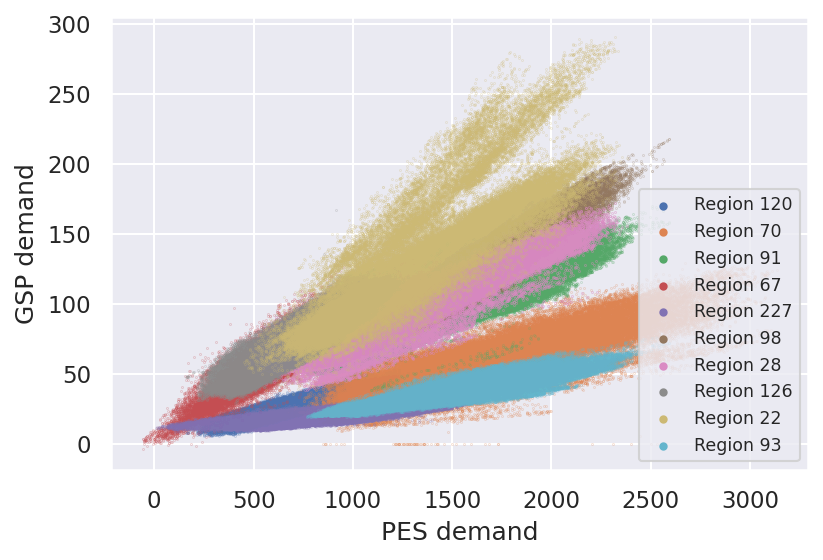

In [7]:
for region_id in np.random.choice(pes_gsp_data.region_id_20210423.unique(), size=10, replace=False):
    pes_gsp_data_ = pes_gsp_data[pes_gsp_data.region_id_20210423 == region_id]
    plt.scatter(x="pes_meter_volume", y="gsp_meter_volume", data=pes_gsp_data_, s=0.01, label=f"Region {region_id}");
    res = stats.linregress(pes_gsp_data_["pes_meter_volume"], pes_gsp_data_["gsp_meter_volume"])
    print(f"RegionID {region_id}... Linear fit: y = {res.slope:.2f}x + {res.intercept:.2f} (r-squared: {res.rvalue**2:.3f})")
plt.xlabel("PES demand")
plt.ylabel("GSP demand")
plt.legend(loc="lower right", fontsize="x-small", markerscale=30);
plt.show()

### Define features and response

In [8]:
# Numerical columns
num_cols = [
    ### PV features ###
    "pv_yield_mw_per_mwp",
    "pv_cumul_instcap_mwp",
    # "pv_generation_mw",
    ### GEOMNI features ###
    "mean_building_area",
    "mean_address_area",
    "mean_gross_area",
    "mean_bathroom_count",
    "mean_bedroom_count",
    "mean_reception_room_count",
    "mean_extension_count",
    "n_uprn_geomni",
    "n_premises",
    #"proportion_premise_use_warehousing_with_office",
    #"proportion_premise_use_health",
    #"proportion_premise_use_retail_under_office",
    #"proportion_premise_use_under_construction",
    #"proportion_premise_use_unclassified",
    # "proportion_premise_use_educational",
    #"proportion_premise_use_institutional_accommodation",
    #"proportion_premise_use_defence",
    "proportion_premise_use_transport",
    #"proportion_premise_use_office_under_retail",
    #"proportion_premise_use_petrol_station",
    #"proportion_premise_use_residential_with_retail_below",
    # "proportion_premise_use_utilities",
    #"proportion_premise_use_unknown",
    "proportion_premise_use_residential",
    "proportion_premise_use_warehousing",
    #"proportion_premise_use_emergency_services",
    "proportion_premise_use_retail",
    #"proportion_premise_use_retail_below_office_or_residential",
    #"proportion_premise_use_mixed_use_including_residential",
    #"proportion_premise_use_retail_with_extensions",
    "proportion_premise_use_commercial_-_mixed_use",
    # "proportion_premise_use_recreation_and_leisure",
    "proportion_premise_use_office",
    #"proportion_premise_use_religious",
    #"proportion_premise_use_governmental",
    #"proportion_premise_use_vacant_retail",
    #"proportion_premise_use_commercial_-_derelict",
    "proportion_premise_use_industry",
    "proportion_premise_use_agricultural",
    #"proportion_premise_type_standard_size_semi_detached",
    #"proportion_premise_type_small_low_terraces",
    #"proportion_premise_type_semi_type_house_in_multiples",
    #"proportion_premise_type_large_detached",
    #"proportion_premise_type_planned_balanced_mixed_estates",
    #"proportion_premise_type_medium_height_flats_5-6_storeys",
    #"proportion_premise_type_non_residential_building",
    #"proportion_premise_type_unknown",
    #"proportion_premise_type_tall_flats_6-15_storeys",
    #"proportion_premise_type_3-4_storey_and_smaller_flats",
    #"proportion_premise_type_domestic_outbuilding",
    #"proportion_premise_type_very_large_detached",
    #"proportion_premise_type_large_semi_detached",
    #"proportion_premise_type_very_tall_point_block_flats",
    #"proportion_premise_type_unkown",
    #"proportion_premise_type_tall_terraces_3-4_storeys",
    #"proportion_premise_type_2_storeys_terraces_with_t_rear_extension",
    #"proportion_premise_type_linked_and_step_linked_premises",
    #"proportion_premise_type_mixed_housing_in_small_settlements",
    #"proportion_premise_type_standard_size_detached",
    ### MOSAIC features ###
    "n_uprn_mosaic",
    "proportion_mosaic_uk_7_group_a",
    "proportion_mosaic_uk_7_group_b",
    "proportion_mosaic_uk_7_group_c",
    "proportion_mosaic_uk_7_group_d",
    "proportion_mosaic_uk_7_group_e",
    "proportion_mosaic_uk_7_group_f",
    "proportion_mosaic_uk_7_group_g",
    "proportion_mosaic_uk_7_group_h",
    "proportion_mosaic_uk_7_group_i",
    "proportion_mosaic_uk_7_group_j",
    "proportion_mosaic_uk_7_group_k",
    "proportion_mosaic_uk_7_group_l",
    "proportion_mosaic_uk_7_group_m",
    "proportion_mosaic_uk_7_group_n",
    "proportion_mosaic_uk_7_group_o",
    "proportion_mosaic_uk_7_group_u",
    "proportion_mosaic_uk_7_group_unkown",
    # "proportion_mosaic_uk_7_full_62o",
    # "proportion_mosaic_uk_7_full_60n",
    # "proportion_mosaic_uk_7_full_64o",
    # "proportion_mosaic_uk_7_full_44k",
    # "proportion_mosaic_uk_7_full_02a",
    # "proportion_mosaic_uk_7_full_04a",
    # "proportion_mosaic_uk_7_full_47k",
    # "proportion_mosaic_uk_7_full_49l",
    # "proportion_mosaic_uk_7_full_61o",
    # "proportion_mosaic_uk_7_full_43j",
    # "proportion_mosaic_uk_7_full_63o",
    # "proportion_mosaic_uk_7_full_46k",
    # "proportion_mosaic_uk_7_full_48k",
    # "proportion_mosaic_uk_7_full_06b",
    # "proportion_mosaic_uk_7_full_35h",
    # "proportion_mosaic_uk_7_full_05b",
    # "proportion_mosaic_uk_7_full_51l",
    # "proportion_mosaic_uk_7_full_45k",
    # "proportion_mosaic_uk_7_full_41j",
    # "proportion_mosaic_uk_7_full_27g",
    # "proportion_mosaic_uk_7_full_26g",
    # "proportion_mosaic_uk_7_full_18e",
    # "proportion_mosaic_uk_7_full_09b",
    # "proportion_mosaic_uk_7_full_22f",
    # "proportion_mosaic_uk_7_full_24f",
    # "proportion_mosaic_uk_7_full_57n",
    # "proportion_mosaic_uk_7_full_20e",
    # "proportion_mosaic_uk_7_full_23f",
    # "proportion_mosaic_uk_7_full_25f",
    # "proportion_mosaic_uk_7_full_32h",
    # "proportion_mosaic_uk_7_full_21e",
    # "proportion_mosaic_uk_7_full_29g",
    # "proportion_mosaic_uk_7_full_08b",
    # "proportion_mosaic_uk_7_full_07b",
    # "proportion_mosaic_uk_7_full_30h",
    # "proportion_mosaic_uk_7_full_40j",
    # "proportion_mosaic_uk_7_full_31h",
    # "proportion_mosaic_uk_7_full_55m",
    # "proportion_mosaic_uk_7_full_52l",
    # "proportion_mosaic_uk_7_full_36i",
    # "proportion_mosaic_uk_7_full_53l",
    # "proportion_mosaic_uk_7_full_42j",
    # "proportion_mosaic_uk_7_full_54m",
    # "proportion_mosaic_uk_7_full_56m",
    # "proportion_mosaic_uk_7_full_38i",
    # "proportion_mosaic_uk_7_full_37i",
    # "proportion_mosaic_uk_7_full_39i",
    # "proportion_mosaic_uk_7_full_50l",
    # "proportion_mosaic_uk_7_full_66o",
    # "proportion_mosaic_uk_7_full_33h",
    # "proportion_mosaic_uk_7_full_65o",
    # "proportion_mosaic_uk_7_full_34h",
    # "proportion_mosaic_uk_7_full_58n",
    # "proportion_mosaic_uk_7_full_01a",
    # "proportion_mosaic_uk_7_full_28g",
    # "proportion_mosaic_uk_7_full_16d",
    # "proportion_mosaic_uk_7_full_19e",
    # "proportion_mosaic_uk_7_full_13c",
    # "proportion_mosaic_uk_7_full_14d",
    # "proportion_mosaic_uk_7_full_10c",
    # "proportion_mosaic_uk_7_full_11c",
    # "proportion_mosaic_uk_7_full_15d",
    # "proportion_mosaic_uk_7_full_12c",
    # "proportion_mosaic_uk_7_full_59n",
    # "proportion_mosaic_uk_7_full_17d",
    # "proportion_mosaic_uk_7_full_03a",
    # "proportion_mosaic_uk_7_full_99u",
    # "proportion_mosaic_uk_7_full_nonenone",
    # "proportion_mosaic_uk_7_full_nannan",
    # "gsp_region_area",
]

# Categorical (or ordinal) columns
cat_cols = [
    "weekday",
    "bank_holiday"
]

# Cyclical columns
cyc_cols = [
    "minute_of_day",
    "month",
]

# Response variable
pes_gsp_data["gsp_pes_ratio"] = pes_gsp_data.gsp_meter_volume / pes_gsp_data.pes_meter_volume
target_col = "gsp_pes_ratio"

### Add some more features that might help

In [9]:
# pes_gsp_data["day_of_week"] = pes_gsp_data["timestamp"].dt.dayofweek
# cat_cols.append("day_of_week")
pes_gsp_data["year"] = pes_gsp_data["timestamp"].dt.year
num_cols.append("year")
pes_gsp_data["minute_of_day"] = pes_gsp_data["timestamp"].dt.hour * 60 + pes_gsp_data["timestamp"].dt.minute

### Drop cols not needed (minimise RAM usage)

In [10]:
needed_cols = num_cols + cat_cols + cyc_cols + [target_col] + ["timestamp", "region_id_20210423", "gsp_meter_volume", "pes_meter_volume"]
pes_gsp_data = pes_gsp_data[[col for col in pes_gsp_data if col in needed_cols]]
gc.collect();

### Convert categorical columns to one hot vector

NOTE: We should consider using cyclical encoding for some temporal features

In [11]:
pes_gsp_data

region_id_20210423                 timestamp  gsp_meter_volume  \
0                          9 2014-01-01 00:30:00+00:00            40.700   
1                          9 2014-01-01 01:00:00+00:00            41.380   
2                          9 2014-01-01 01:30:00+00:00            40.120   
3                          9 2014-01-01 02:00:00+00:00            38.200   
4                          9 2014-01-01 02:30:00+00:00            36.620   
...                      ...                       ...               ...   
35062614                 253 2021-06-10 21:00:00+00:00            13.060   
35062615                 253 2021-06-10 21:30:00+00:00            12.750   
35062616                 253 2021-06-10 22:00:00+00:00            12.410   
35062617                 253 2021-06-10 22:30:00+00:00            11.560   
35062618                 253 2021-06-10 23:00:00+00:00            10.705   

          pes_meter_volume  pv_yield_mw_per_mwp  pv_cumul_instcap_mwp  \
0                1747.9728             0.000000              12.43989   
1                1780.9923             0.000000              12.43989   
2                1735.3562             0.000000              12.43989   
3                1653.6627             0.000000              12.43989   
4                1574.1164             0.000000              12.43989   
...                    ...                  ...                   ...   
35062614          418.2716             0.002109               0.77618   
35062615          417.9002             0.000000               0.77618   
35062616          422.2507             0.000000               0.77618   
35062617          390.0615             0.000000               0.77618   
35062618          328.8627             0.000000               0.77618   

          mean_building_area  mean_address_area  mean_gross_area  \
0                   234.7107           163.0276         196.1405   
1                   234.7107           163.0276         196.1405   
2                   234.7107           163.0276         196.1405   
3                   234.7107           163.0276         196.1405   
4                   234.7107           163.0276         196.1405   
...                      ...                ...              ...   
35062614            689.8935           229.8979         353.7150   
35062615            689.8935           229.8979         353.7150   
35062616            689.8935           229.8979         353.7150   
35062617            689.8935           229.8979         353.7150   
35062618            689.8935           229.8979         353.7150   

          mean_bathroom_count  ...  proportion_mosaic_uk_7_group_d  \
0                      1.3378  ...                          0.0117   
1                      1.3378  ...                          0.0117   
2                      1.3378  ...                          0.0117   
3                      1.3378  ...                          0.0117   
4                      1.3378  ...                          0.0117   
...                       ...  ...                             ...   
35062614               1.1715  ...                          0.0000   
35062615               1.1715  ...                          0.0000   
35062616               1.1715  ...                          0.0000   
35062617               1.1715  ...                          0.0000   
35062618               1.1715  ...                          0.0000   

          proportion_mosaic_uk_7_group_c  proportion_mosaic_uk_7_group_u  \
0                                 0.0404                             0.0   
1                                 0.0404                             0.0   
2                                 0.0404                             0.0   
3                                 0.0404                             0.0   
4                                 0.0404                             0.0   
...                                  ...                             ...   
35062614                      

In [12]:
pes_gsp_data, cat_cols = expand_1hot_cols(pes_gsp_data, cat_cols)
pes_gsp_data.head()

Expanding 'weekday' (1 of 2)...
    -> added 2 new cols
Expanding 'bank_holiday' (2 of 2)...
    -> added 2 new cols


region_id_20210423                 timestamp  gsp_meter_volume  \
0                   9 2014-01-01 00:30:00+00:00             40.70   
1                   9 2014-01-01 01:00:00+00:00             41.38   
2                   9 2014-01-01 01:30:00+00:00             40.12   
3                   9 2014-01-01 02:00:00+00:00             38.20   
4                   9 2014-01-01 02:30:00+00:00             36.62   

   pes_meter_volume  pv_yield_mw_per_mwp  pv_cumul_instcap_mwp  \
0         1747.9728                  0.0              12.43989   
1         1780.9923                  0.0              12.43989   
2         1735.3562                  0.0              12.43989   
3         1653.6627                  0.0              12.43989   
4         1574.1164                  0.0              12.43989   

   mean_building_area  mean_address_area  mean_gross_area  \
0            234.7107           163.0276         196.1405   
1            234.7107           163.0276         196.1405   
2            234.7107           163.0276         196.1405   
3            234.7107           163.0276         196.1405   
4            234.7107           163.0276         196.1405   

   mean_bathroom_count  ...  bank_holiday  weekday  month  gsp_pes_ratio  \
0               1.3378  ...          True     True      1       0.023284   
1               1.3378  ...          True     True      1       0.023234   
2               1.3378  ...          True     True      1       0.023119   
3               1.3378  ...          True     True      1       0.023100   
4               1.3378  ...          True     True      1       0.023264   

   year  minute_of_day  weekday/False  weekday/True  bank_holiday/False  \
0  2014             30              0             1                   0   
1  2014             60              0             1                   0   
2  2014             90              0             1                   0   
3  2014            120              0             1                   0   
4  2014            150              0             1                   0   

   bank_holiday/True  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  

[5 rows x 51 columns]

### Encode cyclical columns

In [13]:
cyc_cols

['minute_of_day', 'month']

In [14]:
pes_gsp_data, cyc_cols = encode_cyclical_cols(pes_gsp_data, cyc_cols, max_vals=[24, 12])
pes_gsp_data.head()

Applying cyclical encoding to 'minute_of_day' (1 of 2)...
Applying cyclical encoding to 'month' (2 of 2)...


region_id_20210423                 timestamp  gsp_meter_volume  \
0                   9 2014-01-01 00:30:00+00:00             40.70   
1                   9 2014-01-01 01:00:00+00:00             41.38   
2                   9 2014-01-01 01:30:00+00:00             40.12   
3                   9 2014-01-01 02:00:00+00:00             38.20   
4                   9 2014-01-01 02:30:00+00:00             36.62   

   pes_meter_volume  pv_yield_mw_per_mwp  pv_cumul_instcap_mwp  \
0         1747.9728                  0.0              12.43989   
1         1780.9923                  0.0              12.43989   
2         1735.3562                  0.0              12.43989   
3         1653.6627                  0.0              12.43989   
4         1574.1164                  0.0              12.43989   

   mean_building_area  mean_address_area  mean_gross_area  \
0            234.7107           163.0276         196.1405   
1            234.7107           163.0276         196.1405   
2            234.7107           163.0276         196.1405   
3            234.7107           163.0276         196.1405   
4            234.7107           163.0276         196.1405   

   mean_bathroom_count  ...  year  minute_of_day  weekday/False  weekday/True  \
0               1.3378  ...  2014             30              0             1   
1               1.3378  ...  2014             60              0             1   
2               1.3378  ...  2014             90              0             1   
3               1.3378  ...  2014            120              0             1   
4               1.3378  ...  2014            150              0             1   

   bank_holiday/False  bank_holiday/True  minute_of_day_sin  \
0                   0                  1       1.000000e+00   
1                   0                  1       2.388680e-15   
2                   0                  1      -1.000000e+00   
3                   0                  1      -4.777360e-15   
4                   0                  1       1.000000e+00   

   minute_of_day_cos  month_sin  month_cos  
0       1.194340e-15        0.5   0.866025  
1      -1.000000e+00        0.5   0.866025  
2       8.578717e-16        0.5   0.866025  
3       1.000000e+00        0.5   0.866025  
4      -2.455483e-16        0.5   0.866025  

[5 rows x 55 columns]

### Split the training data into train/validation/test subsets

NOTE: We should consider using stratified sampling for the subsets and / or choosing contiguous blocks of time to avoid testing our ability to interpolate

In [15]:
gc.collect();

In [16]:
train_ratio = .80
valid_ratio = .10
test_ratio = .10

pes_gsp_data = train_test_split_by_col(pes_gsp_data, train_ratio, valid_ratio, test_ratio, "region_id_20210423")

print(f"{len(pes_gsp_data[pes_gsp_data.set=='train'].region_id_20210423.unique())} GSPs in training set")
print(f"{len(pes_gsp_data[pes_gsp_data.set=='valid'].region_id_20210423.unique())} GSPs in validation set")
print(f"{len(pes_gsp_data[pes_gsp_data.set=='test'].region_id_20210423.unique())} GSPs in test set")
print(pes_gsp_data["set"].value_counts())

108 GSPs in training set
13 GSPs in validation set
15 GSPs in test set
train    16046703
test      2087376
valid     1956915
Name: set, dtype: int64


### Normalise numerical features

In [17]:
pes_gsp_data.groupby("set")[num_cols].mean()

pv_yield_mw_per_mwp  pv_cumul_instcap_mwp  mean_building_area  \
set                                                                    
test              0.099449             53.097969          316.926600   
train             0.101151             45.365177         1117.000817   
valid             0.101425             61.400037         1016.246240   

       mean_address_area  mean_gross_area  mean_bathroom_count  \
set                                                              
test          173.386475       228.500550             1.116331   
train         177.259742       245.550623             1.119384   
valid         174.019587       240.649453             1.109093   

       mean_bedroom_count  mean_reception_room_count  mean_extension_count  \
set                                                                          
test             2.352175                   1.357163              0.061119   
train            2.323037                   1.354437              0.084407   
valid            2.311000                   1.343100              0.082713   

       n_uprn_geomni  ...  proportion_mosaic_uk_7_group_i  \
set                   ...                                   
test   167406.375000  ...                        0.072306   
train  164064.365854  ...                        0.083045   
valid  163145.066667  ...                        0.081093   

       proportion_mosaic_uk_7_group_j  proportion_mosaic_uk_7_group_k  \
set                                                                     
test                         0.041900                        0.087587   
train                        0.049359                        0.081966   
valid                        0.044247                        0.086027   

       proportion_mosaic_uk_7_group_l  proportion_mosaic_uk_7_group_m  \
set                                                                     
test                         0.075719                        0.046894   
train                        0.067627                        0.053546   
valid                        0.064193                        0.051160   

       proportion_mosaic_uk_7_group_n  proportion_mosaic_uk_7_group_o  \
set                                                                     
test                         0.040256                        0.107906   
train                        0.057889                        0.086273   
valid                        0.044733                        0.072220   

       proportion_mosaic_uk_7_group_u  proportion_mosaic_uk_7_group_unkown  \
set                                                                          
test                         0.000406                             0.000000   
train                        0.000306                             0.000003   
valid                        0.000267                             0.000000   

             year  
set                
test   2017.23768  
train  2017.23768  
valid  2017.23768  

[3 rows x 38 columns]

In [18]:
# Normalizing the numerical columns
pes_gsp_data, x_train_mean, x_train_std = normalise_cols(pes_gsp_data, num_cols)

In [19]:
pes_gsp_data.groupby("set")[num_cols].mean()

pv_yield_mw_per_mwp  pv_cumul_instcap_mwp  mean_building_area  \
set                                                                    
test         -9.876128e-03          9.159728e-02       -2.165318e-01   
train         5.754377e-16         -9.982298e-16        1.883416e-15   
valid         1.590894e-03          1.899378e-01       -2.726818e-02   

       mean_address_area  mean_gross_area  mean_bathroom_count  \
set                                                              
test       -9.174970e-02    -8.185945e-02        -1.896090e-02   
train      -1.967726e-14     4.594729e-15         6.253410e-15   
valid      -7.675259e-02    -2.353110e-02        -6.392007e-02   

       mean_bedroom_count  mean_reception_room_count  mean_extension_count  \
set                                                                          
test         1.113403e-01               1.693427e-02         -5.534651e-01   
train        2.376398e-14               1.866015e-14          4.394605e-15   
valid       -4.599279e-02              -7.042655e-02         -4.025842e-02   

       n_uprn_geomni  ...  proportion_mosaic_uk_7_group_i  \
set                   ...                                   
test    3.153262e-02  ...                   -2.153052e-01   
train   8.261797e-17  ...                   -1.943215e-15   
valid  -8.673798e-03  ...                   -3.912502e-02   

       proportion_mosaic_uk_7_group_j  proportion_mosaic_uk_7_group_k  \
set                                                                     
test                    -1.936929e-01                    7.849840e-02   
train                    1.761012e-15                   -8.424156e-15   
valid                   -1.327583e-01                    5.670355e-02   

       proportion_mosaic_uk_7_group_l  proportion_mosaic_uk_7_group_m  \
set                                                                     
test                     2.381428e-01                   -1.665797e-01   
train                    6.234512e-15                   -4.282087e-16   
valid                   -1.010467e-01                   -5.975358e-02   

       proportion_mosaic_uk_7_group_n  proportion_mosaic_uk_7_group_o  \
set                                                                     
test                    -1.975387e-01                    2.836418e-01   
train                    6.525057e-15                   -9.281165e-15   
valid                   -1.473811e-01                   -1.842579e-01   

       proportion_mosaic_uk_7_group_u  proportion_mosaic_uk_7_group_unkown  \
set                                                                          
test                     3.041420e-01                        -1.488646e-01   
train                    6.705115e-15                        -1.353931e-16   
valid                   -1.180298e-01                        -1.488646e-01   

               year  
set                  
test   5.981736e-15  
train  5.981736e-15  
valid  5.981736e-15  

[3 rows x 38 columns]

In [20]:
pes_gsp_data.loc[pes_gsp_data.set.isin(["valid", "test"]), num_cols].describe()

pv_yield_mw_per_mwp  pv_cumul_instcap_mwp  mean_building_area  \
count         4.044291e+06          4.044291e+06        4.044291e+06   
mean         -4.327569e-03          1.391814e-01       -1.249526e-01   
std           9.930176e-01          9.277949e-01        4.122077e-01   
min          -5.871901e-01         -5.344849e-01       -2.493136e-01   
25%          -5.871901e-01         -5.166593e-01       -2.377387e-01   
50%          -5.867752e-01         -3.824133e-01       -2.203035e-01   
75%           1.780982e-01          5.809350e-01       -1.959362e-01   
max           4.687525e+00          2.974661e+00        2.096188e+00   

       mean_address_area  mean_gross_area  mean_bathroom_count  \
count       4.044291e+06     4.044291e+06         4.044291e+06   
mean       -8.449304e-02    -5.363606e-02        -4.071534e-02   
std         4.052670e-01     4.401102e-01         7.386027e-01   
min        -6.933753e-01    -3.788354e-01        -1.533547e+00   
25%        -3.619905e-01    -2.341930e-01        -3.620363e-01   
50%        -1.691802e-01    -1.456671e-01        -8.810397e-02   
75%         1.743919e-01    -3.027213e-02         4.901976e-01   
max         1.327142e+00     2.197885e+00         1.482193e+00   

       mean_bedroom_count  mean_reception_room_count  mean_extension_count  \
count        4.044291e+06               4.044291e+06          4.044291e+06   
mean         3.521139e-02              -2.533710e-02         -3.051393e-01   
std          7.220922e-01               8.831399e-01          1.148705e+00   
min         -1.632124e+00              -1.945927e+00         -2.005984e+00   
25%         -5.557253e-01              -7.842227e-01         -2.005984e+00   
50%          1.653131e-01              -5.675944e-02          7.587579e-02   
75%          4.656502e-01               7.005230e-01          5.939643e-01   
max          1.298264e+00               1.640448e+00          1.230880e+00   

       n_uprn_geomni  ...  proportion_mosaic_uk_7_group_i  \
count   4.044291e+06  ...                    4.044291e+06   
mean    1.207790e-02  ...                   -1.300567e-01   
std     1.161268e+00  ...                    1.043240e+00   
min    -1.447622e+00  ...                   -1.665038e+00   
25%    -1.140883e+00  ...                   -6.224435e-01   
50%    -6.502161e-02  ...                   -3.056550e-01   
75%     1.258430e+00  ...                    4.722322e-02   
max     2.041525e+00  ...                    4.333892e+00   

       proportion_mosaic_uk_7_group_j  proportion_mosaic_uk_7_group_k  \
count                    4.044291e+06                    4.044291e+06   
mean                    -1.642084e-01                    6.795250e-02   
std                      7.394864e-01                    1.027787e+00   
min                     -1.279091e+00                   -1.037018e+00   
25%                     -7.493751e-01                   -8.359426e-01   
50%                     -2.793822e-01                   -3.667658e-01   
75%                      2.814933e-01                    8.466707e-01   
max                      2.161465e+00                    2.203932e+00   

       proportion_mosaic_uk_7_group_l  proportion_mosaic_uk_7_group_m  \
count                    4.044291e+06                    4.044291e+06   
mean                     7.401882e-02                   -1.148897e-01   
std                      9.067038e-01                    6.822467e-01   
min                     -1.946093e+00                   -1.340791e+00   
25%                     -5.010944e-01                   -4.969490e-01   
50%                     -8.907867e-02                   -3.191662e-01   
75%                      7.732115e-01                    4.470525e-01   
max                      2.006316e+00                    1.546301e+00   

       proportion_mosaic_uk_7_group_n  proportion_mosaic_uk_7_group_o  \
count                    4.044291e+06                    4.044291e+06   
mean                    -1.732689e-01           

### Restructure training data

In [21]:
x_train, y_train = prepare_xy(pes_gsp_data[pes_gsp_data.set=="train"], num_cols, cat_cols, cyc_cols, target_col)
x_valid, y_valid = prepare_xy(pes_gsp_data[pes_gsp_data.set=="valid"], num_cols, cat_cols, cyc_cols, target_col)
x_test, y_test = prepare_xy(pes_gsp_data[pes_gsp_data.set=="test"], num_cols, cat_cols, cyc_cols, target_col)

In [22]:
print("x train shape:", x_train.shape)
print("y train shape:", y_train.shape)
print("x test shape:", x_test.shape)
print("y test shape:", y_test.shape)

x train shape: (16046703, 46)
y train shape: (16046703,)
x test shape: (2087376, 46)
y test shape: (2087376,)


In [23]:
len(pes_gsp_data.columns)

56

## Create the model

#### Extreme gradient boosting

    XGBoost is efficient implementation of the Gradient Boosting method that uses more accurate approximations to find the best tree model. It is not only efficient but also fast. It finds the second-order gradient of the loss function that provides more information about the direction of gradients. Also it uses regularization techniques (L1 & L2), to improve model's generalisation.

    XGBoost has additional advantages: training is very fast and can be parallelized / distributed across clusters.

[Reference](https://xgboost.readthedocs.io/en/stable/python/python_api.html?highlight=XGBRegressor#module-xgboost.core)

[Reference](https://xgboost.readthedocs.io/en/stable/parameter.html)

N.B. This model has already had it's hyperparameters optimised - see `~/Electricity-Demand-Modelling/regional_demand_disaggregation/FY/energy_demand_ratio_xgb_gridsearch_tuned.ipynb`

In [24]:
xgb_reg = xgb.XGBRegressor(random_state=0, eval_metric="mae", colsample_bytree=0.6, 
                           subsample=0.8, min_child_weight=1, 
                           max_depth=4, gamma=2, learning_rate=0.3)

## Train the model

In [25]:
xgb_reg.fit(x_train.to_numpy(), y_train.to_numpy())

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='mae', gamma=2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

### Feature importance representation

In [38]:
pes_gsp_data.columns[:-1]

Index(['region_id_20210423', 'timestamp', 'gsp_meter_volume',
       'pes_meter_volume', 'pv_yield_mw_per_mwp', 'pv_cumul_instcap_mwp',
       'mean_building_area', 'mean_address_area', 'mean_gross_area',
       'mean_bathroom_count', 'mean_bedroom_count',
       'mean_reception_room_count', 'mean_extension_count', 'n_uprn_geomni',
       'n_premises', 'proportion_premise_use_transport',
       'proportion_premise_use_residential',
       'proportion_premise_use_warehousing', 'proportion_premise_use_retail',
       'proportion_premise_use_commercial_-_mixed_use',
       'proportion_premise_use_office', 'proportion_premise_use_industry',
       'proportion_premise_use_agricultural', 'n_uprn_mosaic',
       'proportion_mosaic_uk_7_group_o', 'proportion_mosaic_uk_7_group_n',
       'proportion_mosaic_uk_7_group_k', 'proportion_mosaic_uk_7_group_a',
       'proportion_mosaic_uk_7_group_l', 'proportion_mosaic_uk_7_group_j',
       'proportion_mosaic_uk_7_group_b', 'proportion_mosaic_uk_7_gr

In [27]:
xgb_reg.feature_importances_.shape

(46,)

In [28]:
print(len(num_cols))
print(len(cat_cols))
print(len(cyc_cols))

38
4
4


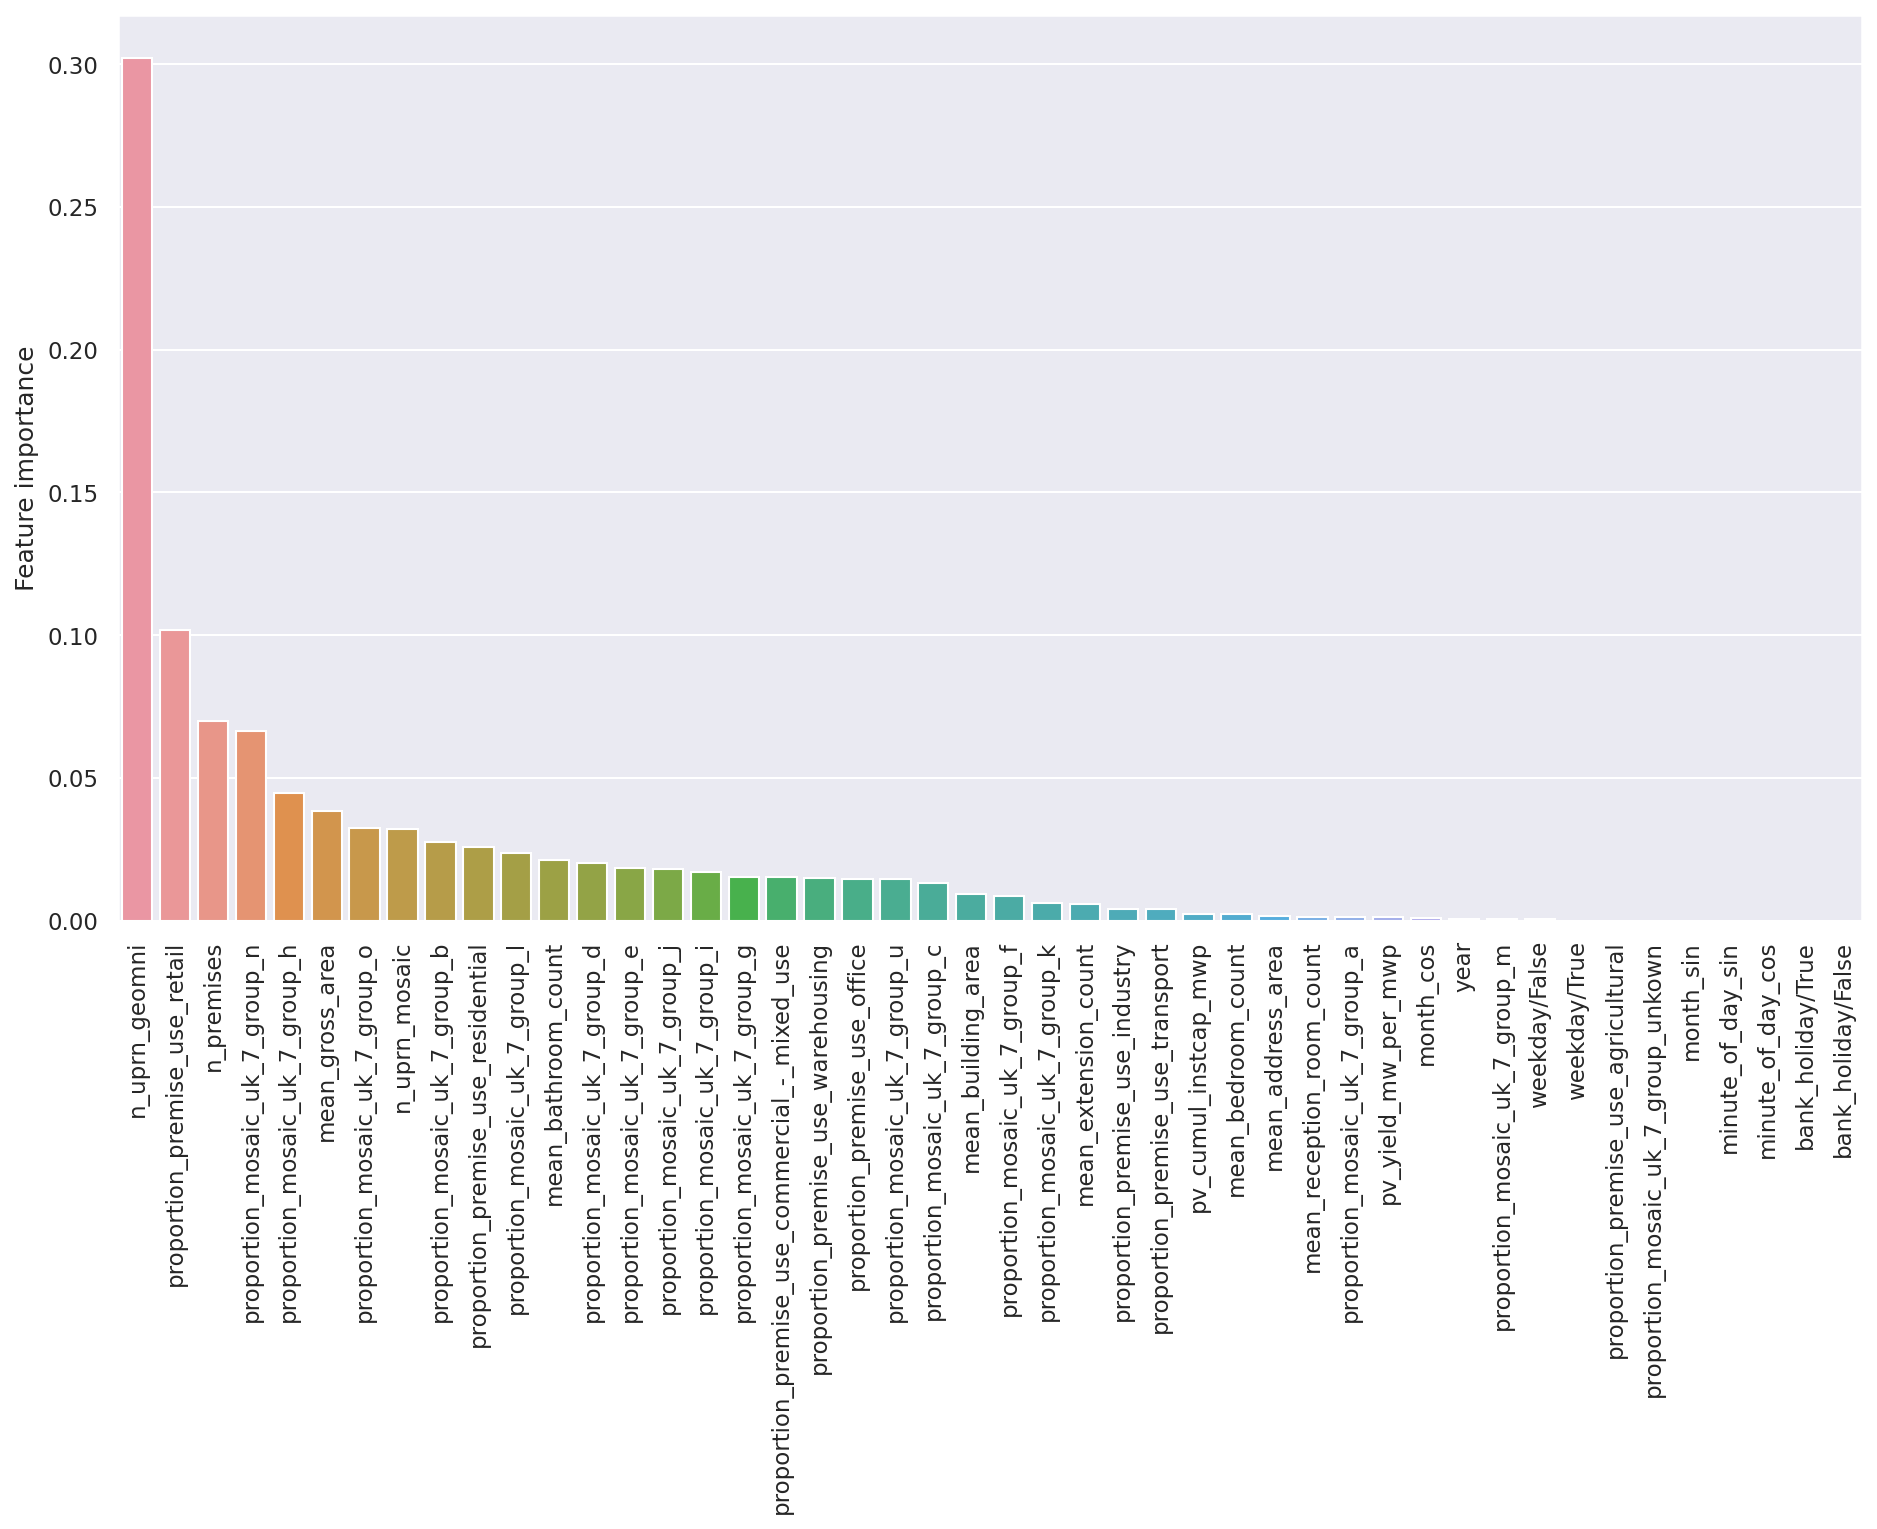

In [29]:
importances = list(zip(xgb_reg.feature_importances_, num_cols + cat_cols + cyc_cols))
importances.sort(reverse=True)
    
feature_names = []
important_features = []
for imp, x in importances:
    feature_names.append(x)
    important_features.append(imp)
    
plt.figure(figsize=(15,8))
plt.ylabel("Feature importance")
plt.xticks(rotation=90)
sns.barplot(x=feature_names, y=important_features);

The coefficient of determination (r-squared):

In [30]:
xgb_reg.score(x_test, y_test)

0.8577715458169591

## Make predictions for the test set

In [31]:
pes_gsp_data.loc[pes_gsp_data.set=="test", "predicted_GSP_PES_ratio"] = xgb_reg.predict(x_test)
pes_gsp_data.loc[pes_gsp_data.set=="test", "predicted_GSP_meter_volume"] = pes_gsp_data.predicted_GSP_PES_ratio * pes_gsp_data.pes_meter_volume
pes_gsp_data.loc[pes_gsp_data.set=="test", "predicted_GSP_meter_volume"]

0           63.543377
1           64.743722
2           63.084731
3           60.114959
4           57.223243
              ...    
34540770    11.705988
34540771    11.695594
34540772    11.817349
34540773    10.916484
34540774     9.203739
Name: predicted_GSP_meter_volume, Length: 2087376, dtype: float64

## Validate model performance

In [32]:
rmse = RootMeanSquaredError()
rmse(pes_gsp_data.loc[pes_gsp_data.set=="test", "gsp_meter_volume"], 
     pes_gsp_data.loc[pes_gsp_data.set=="test", "predicted_GSP_meter_volume"]).numpy()

2022-08-30 13:40:08.169793: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-30 13:40:08.169837: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-30 13:40:08.169870: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ssfvm0): /proc/driver/nvidia/version does not exist
2022-08-30 13:40:08.170112: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


16.59978

Linear fit: y = 1.01x + 6.72 (r-squared: 0.944)


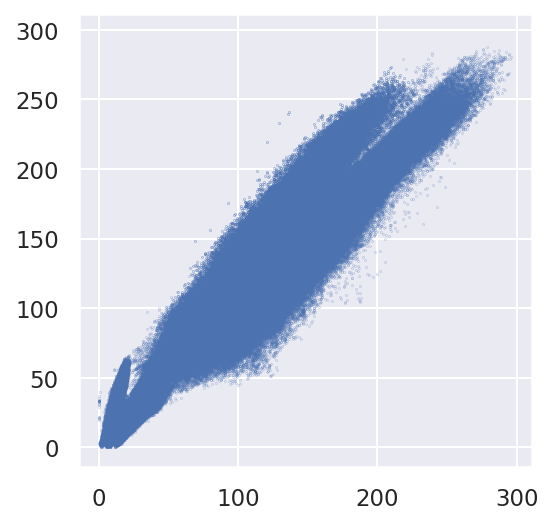

In [33]:
plt.scatter(pes_gsp_data.loc[pes_gsp_data.set=="test", "gsp_meter_volume"], 
            pes_gsp_data.loc[pes_gsp_data.set=="test", "predicted_GSP_meter_volume"], s=0.01);
plt.axis('square');
res = stats.linregress(pes_gsp_data.loc[pes_gsp_data.set=="test", "gsp_meter_volume"], 
                       pes_gsp_data.loc[pes_gsp_data.set=="test", "predicted_GSP_meter_volume"])
print(f"Linear fit: y = {res.slope:.2f}x + {res.intercept:.2f} (r-squared: {res.rvalue**2:.3f})")

In [34]:
import importlib
import validation
importlib.reload(validation);
#validation.run_validation(pes_gsp_data)

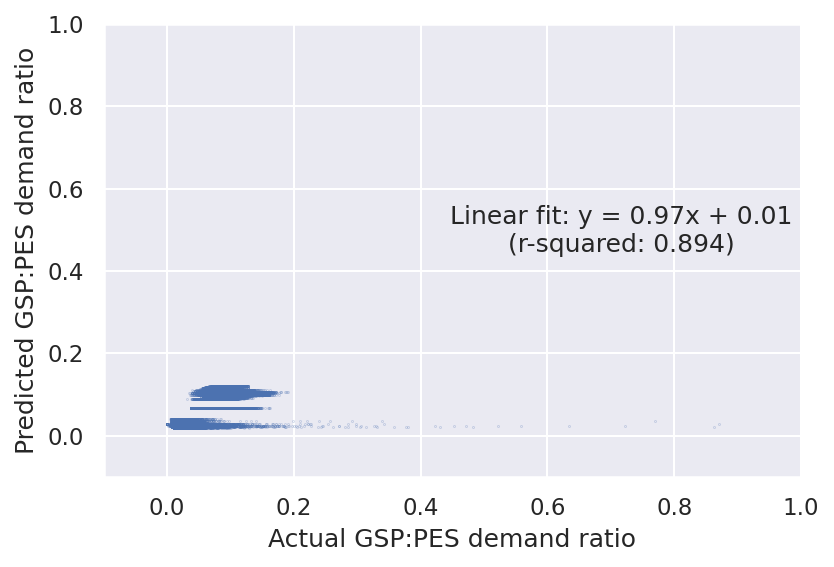

In [35]:
validation.predicted_vs_actual_ratio(pes_gsp_data)

../validation.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 1500x1000 with 0 Axes>

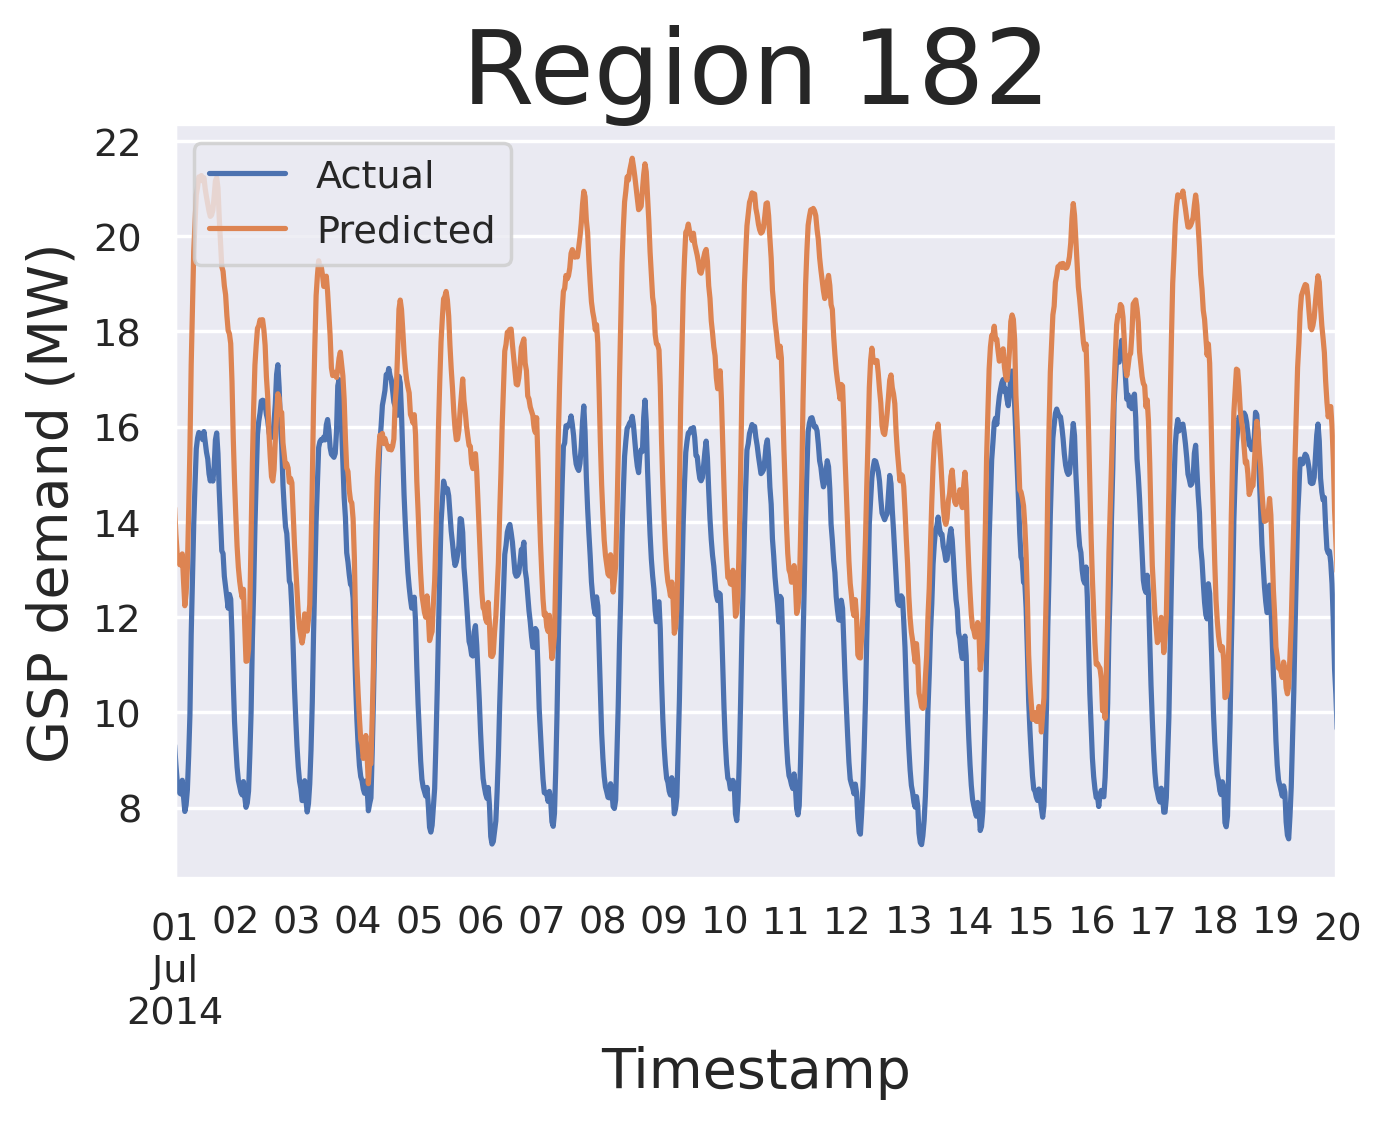

<Figure size 1500x1000 with 0 Axes>

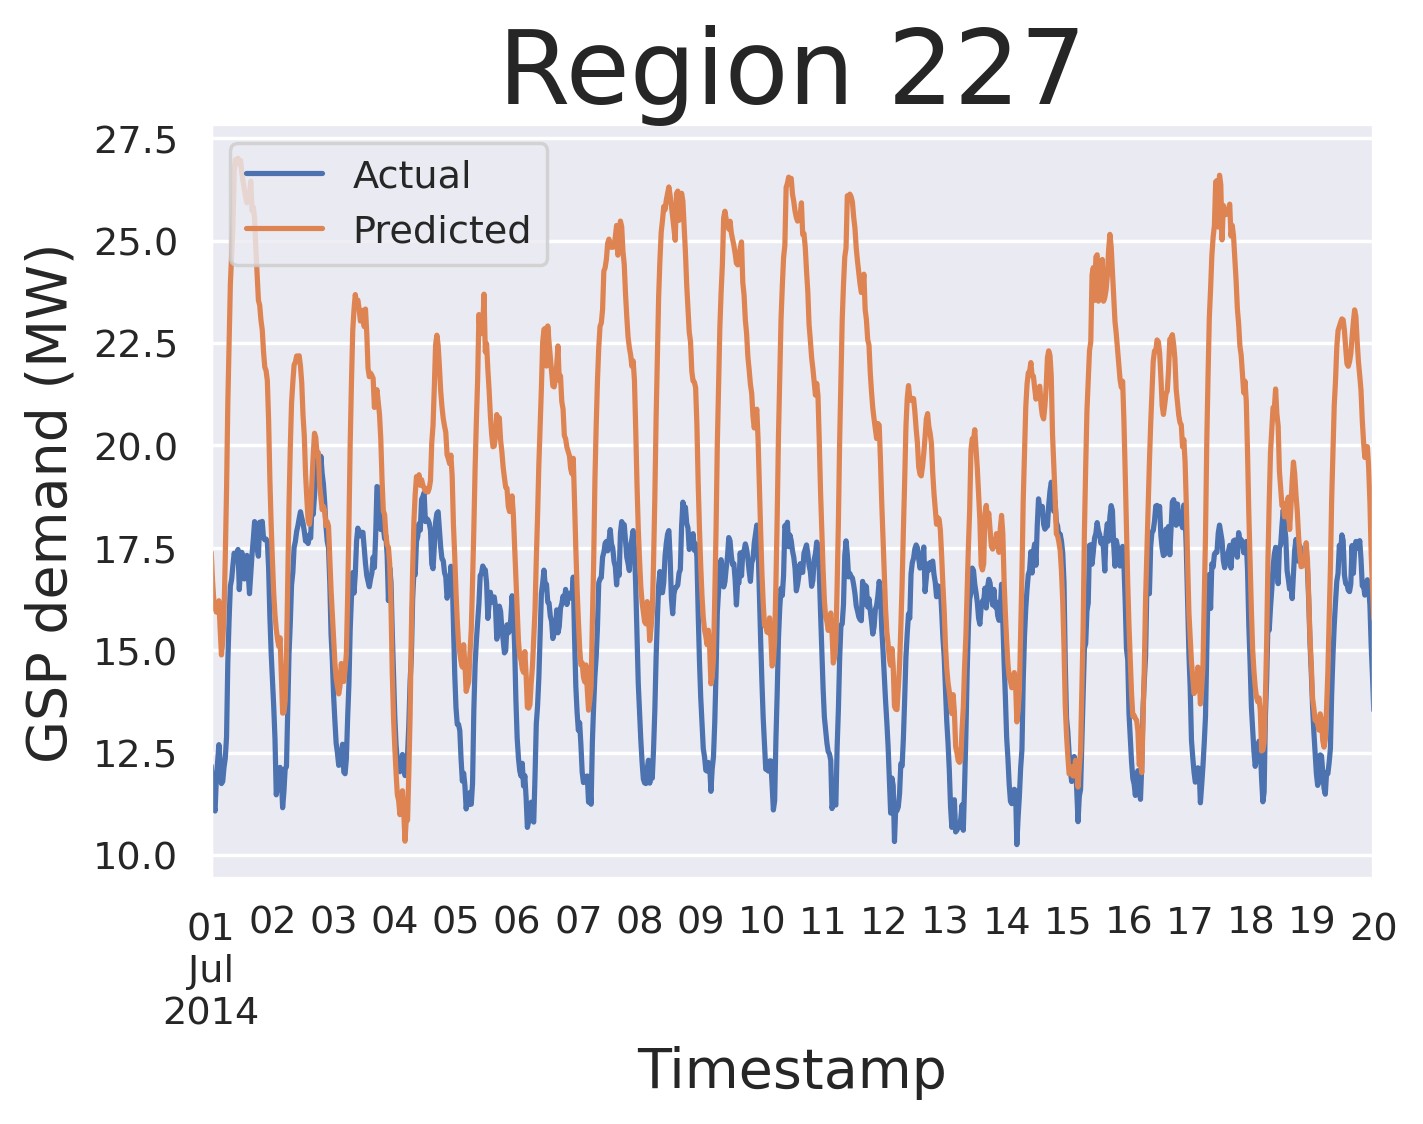

<Figure size 1500x1000 with 0 Axes>

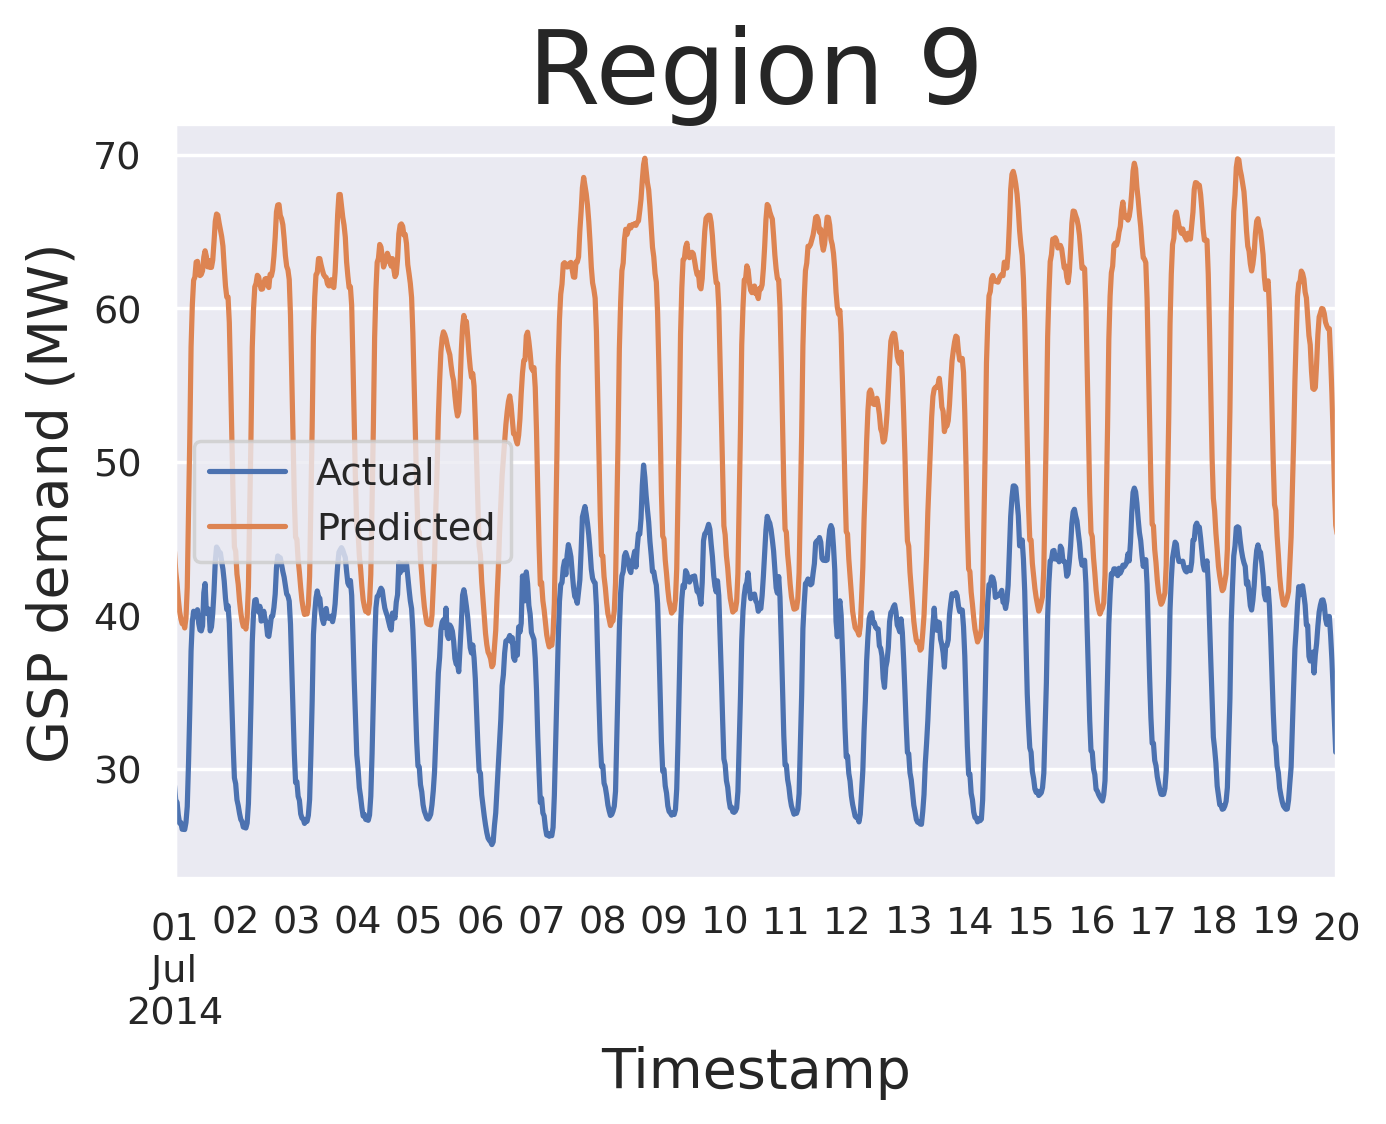

<Figure size 1500x1000 with 0 Axes>

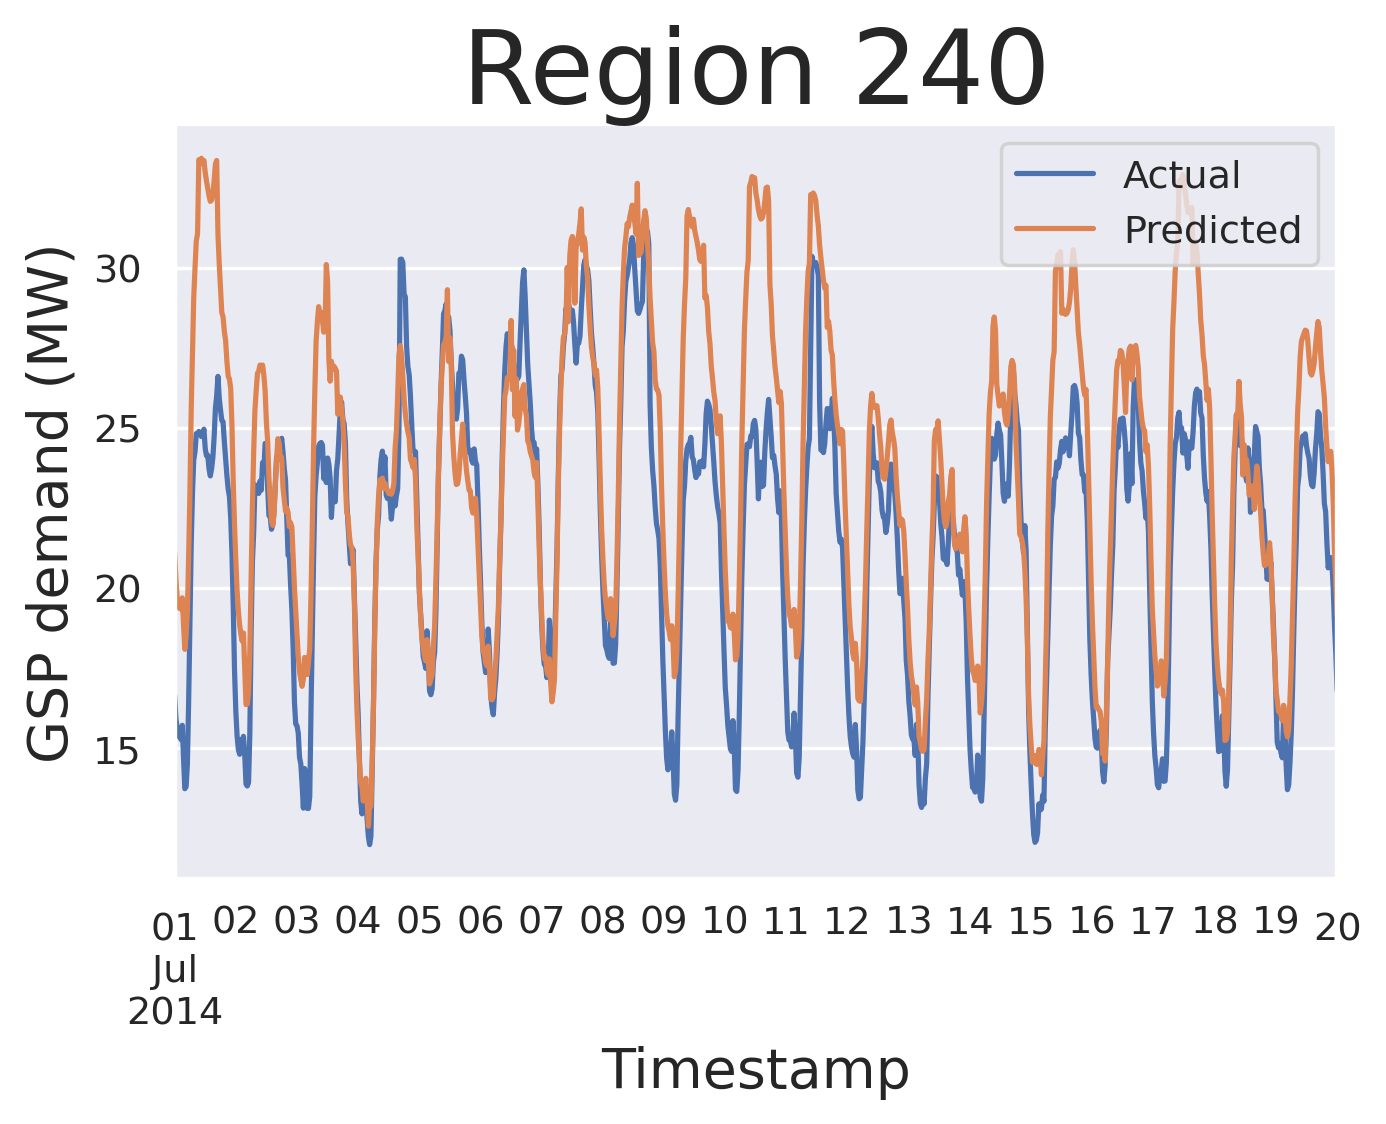

<Figure size 1500x1000 with 0 Axes>

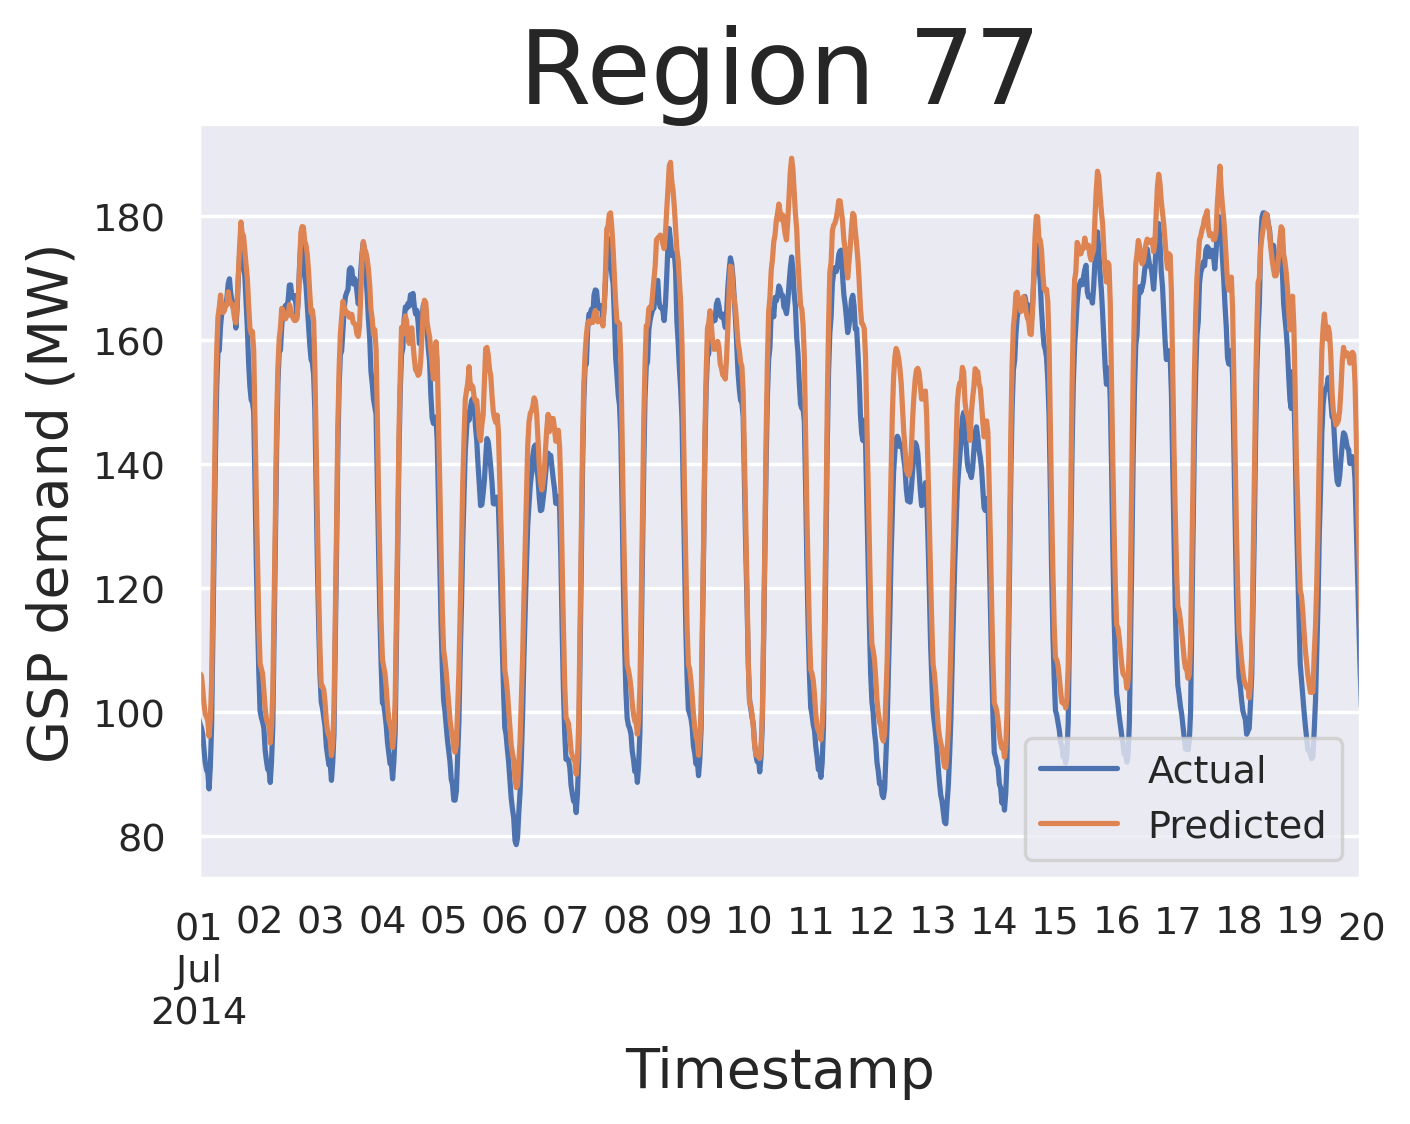

<Figure size 1500x1000 with 0 Axes>

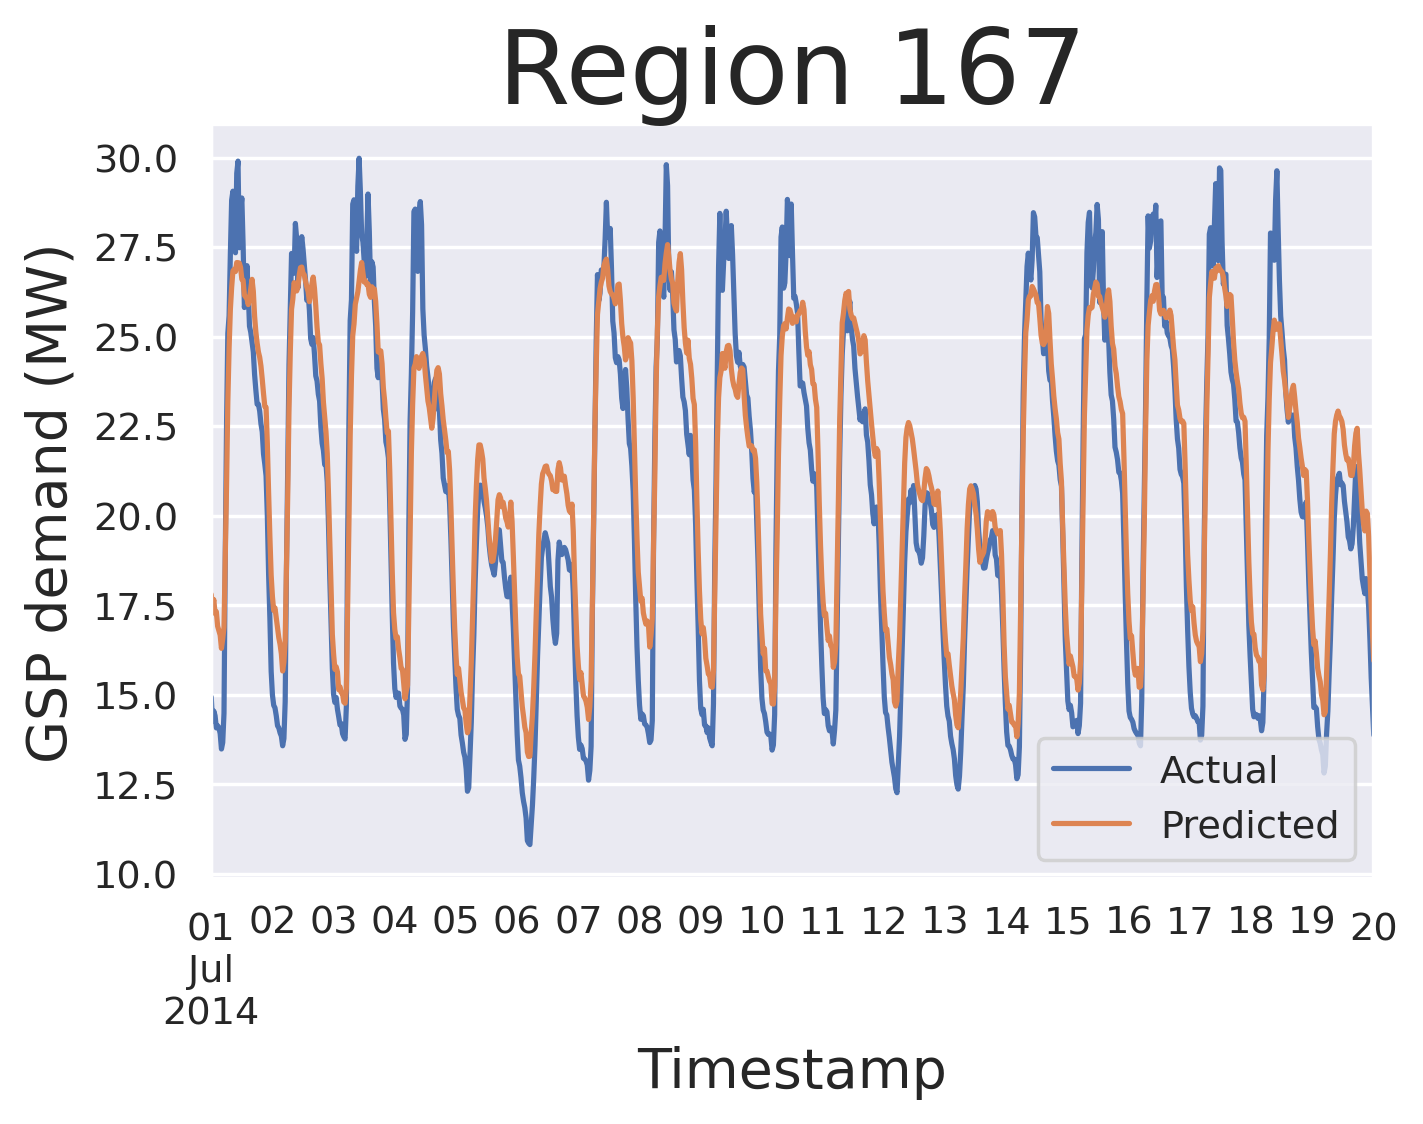

<Figure size 1500x1000 with 0 Axes>

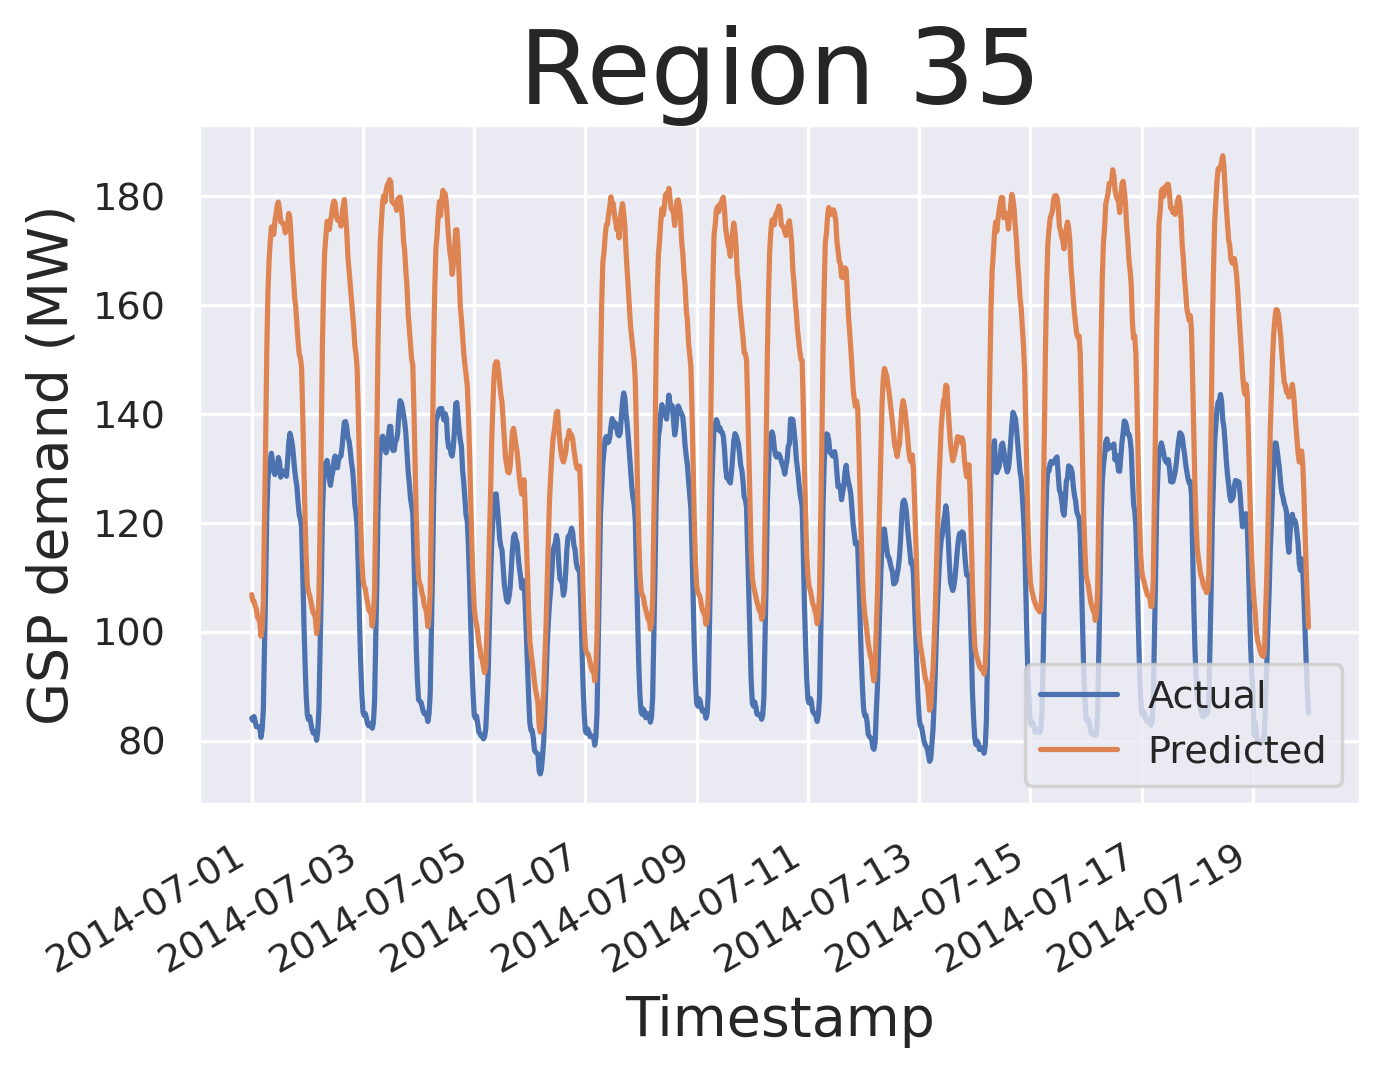

<Figure size 1500x1000 with 0 Axes>

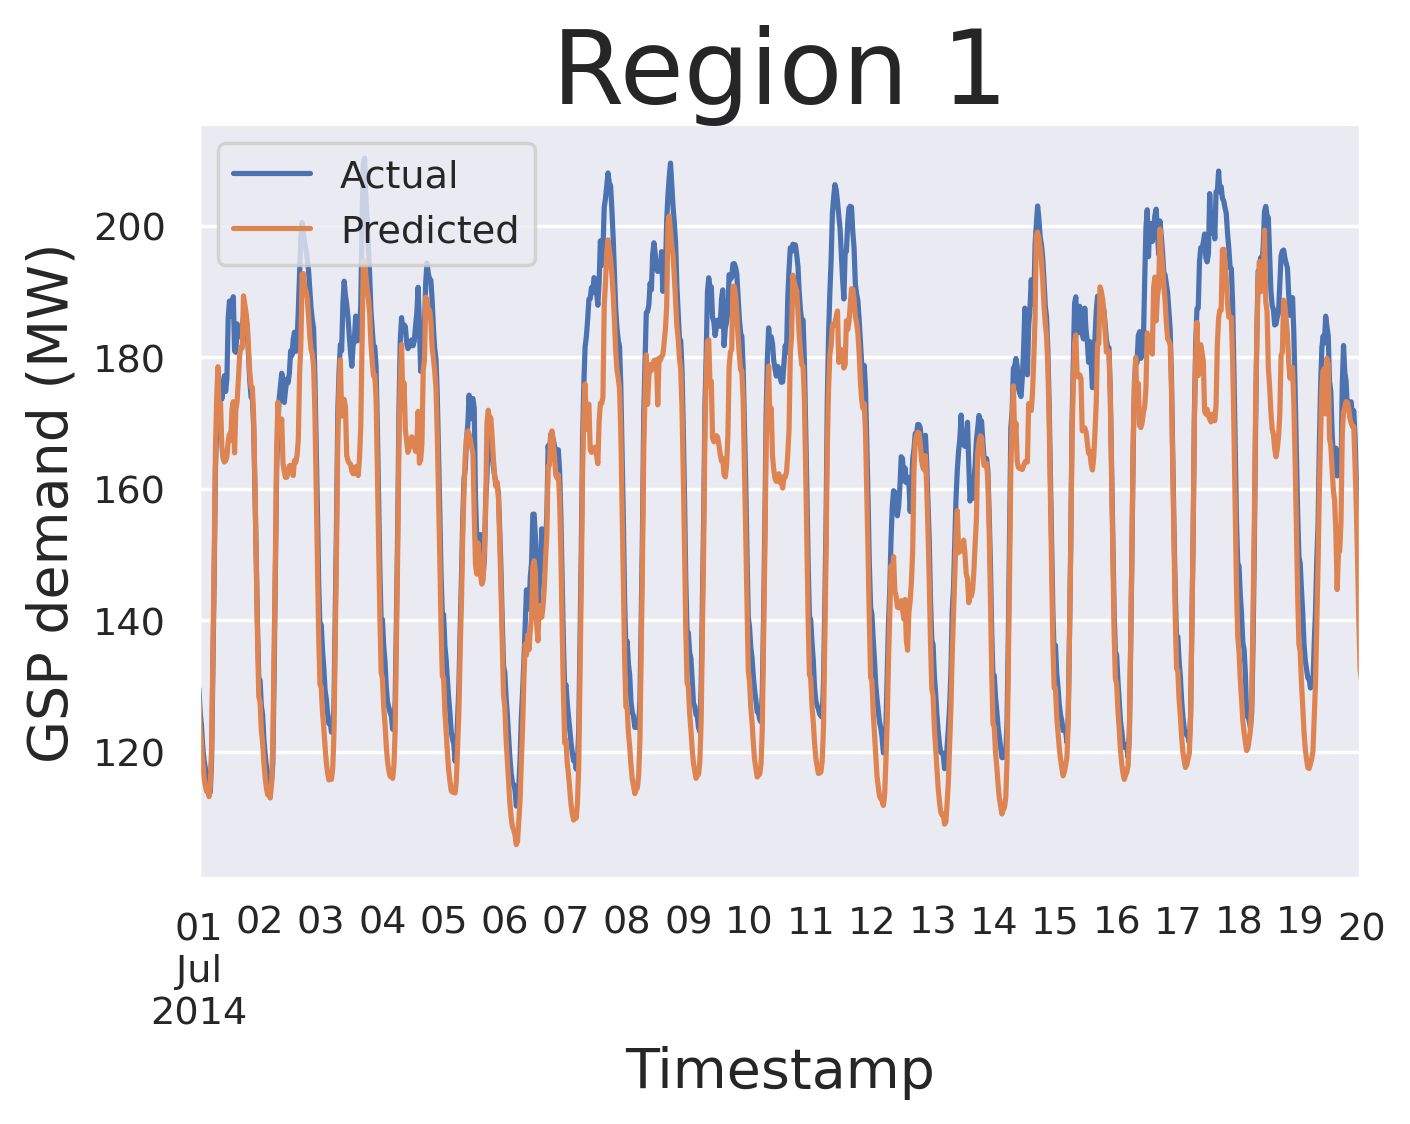

<Figure size 1500x1000 with 0 Axes>

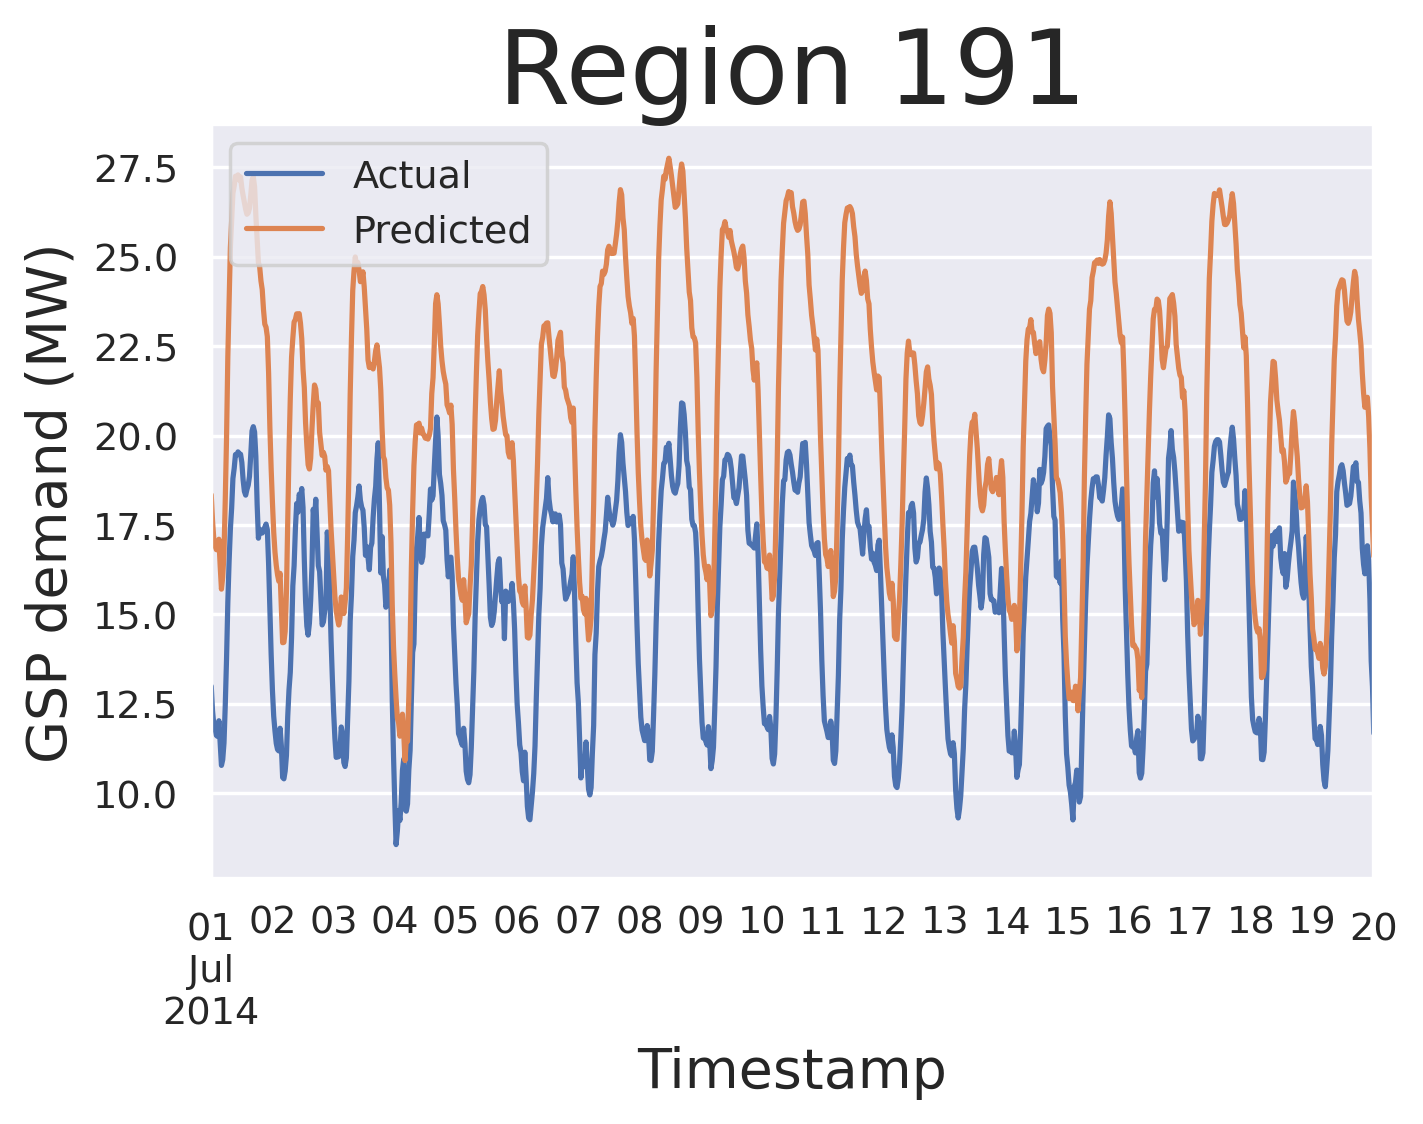

<Figure size 1500x1000 with 0 Axes>

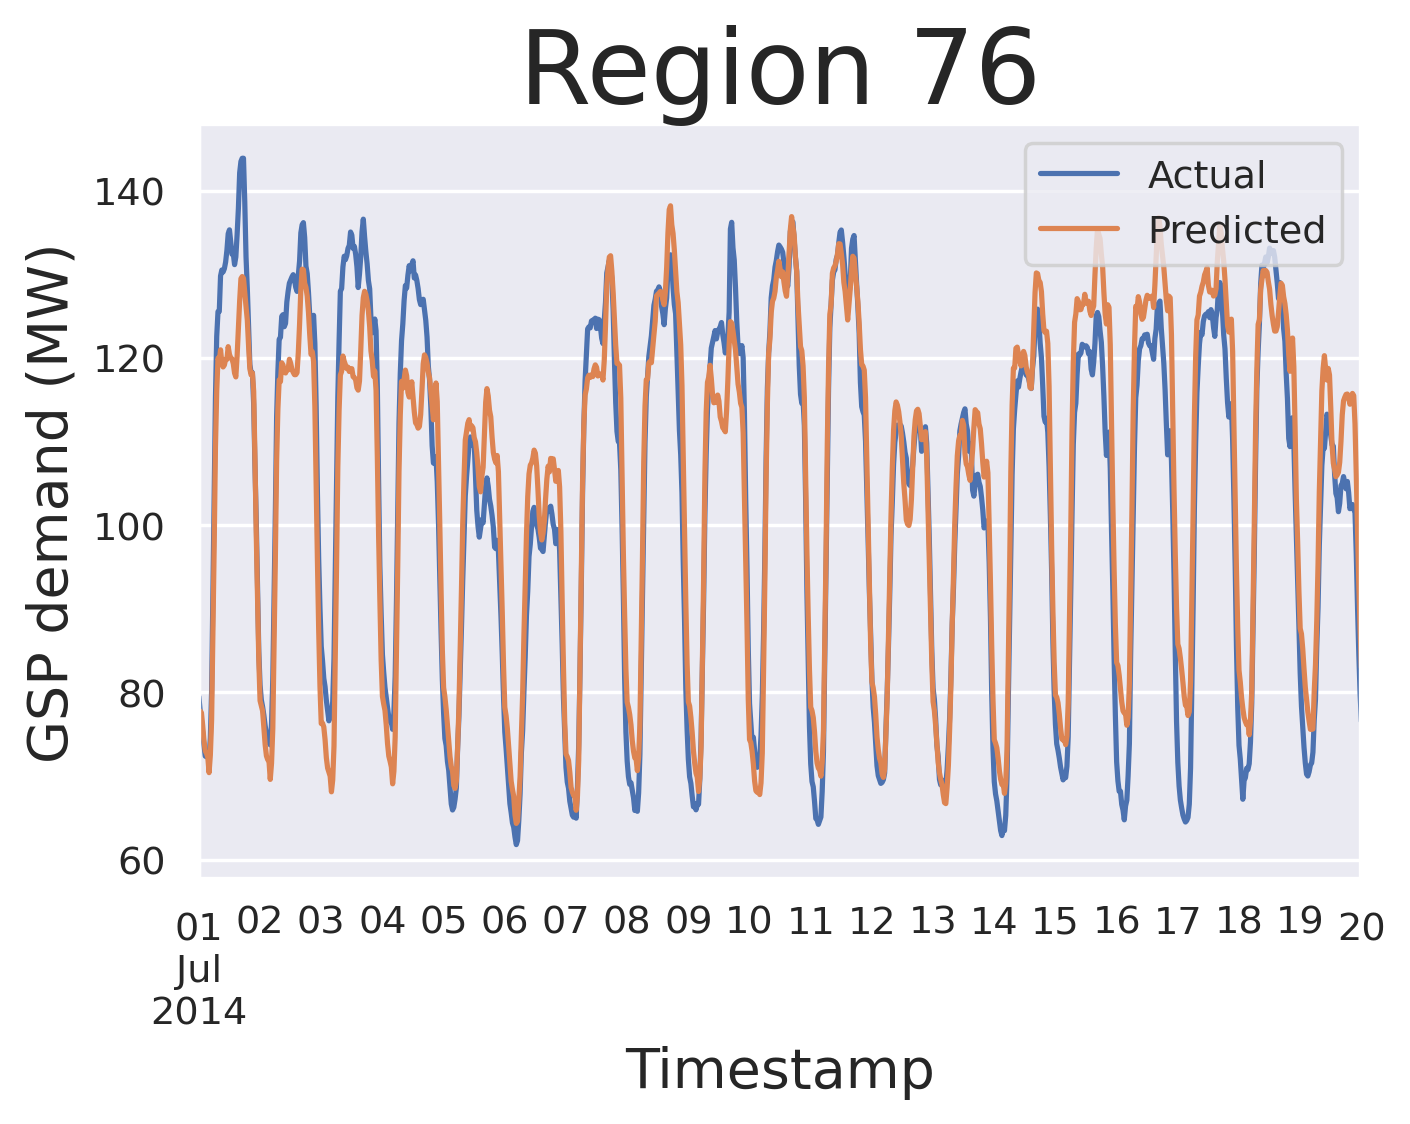

<Figure size 1500x1000 with 0 Axes>

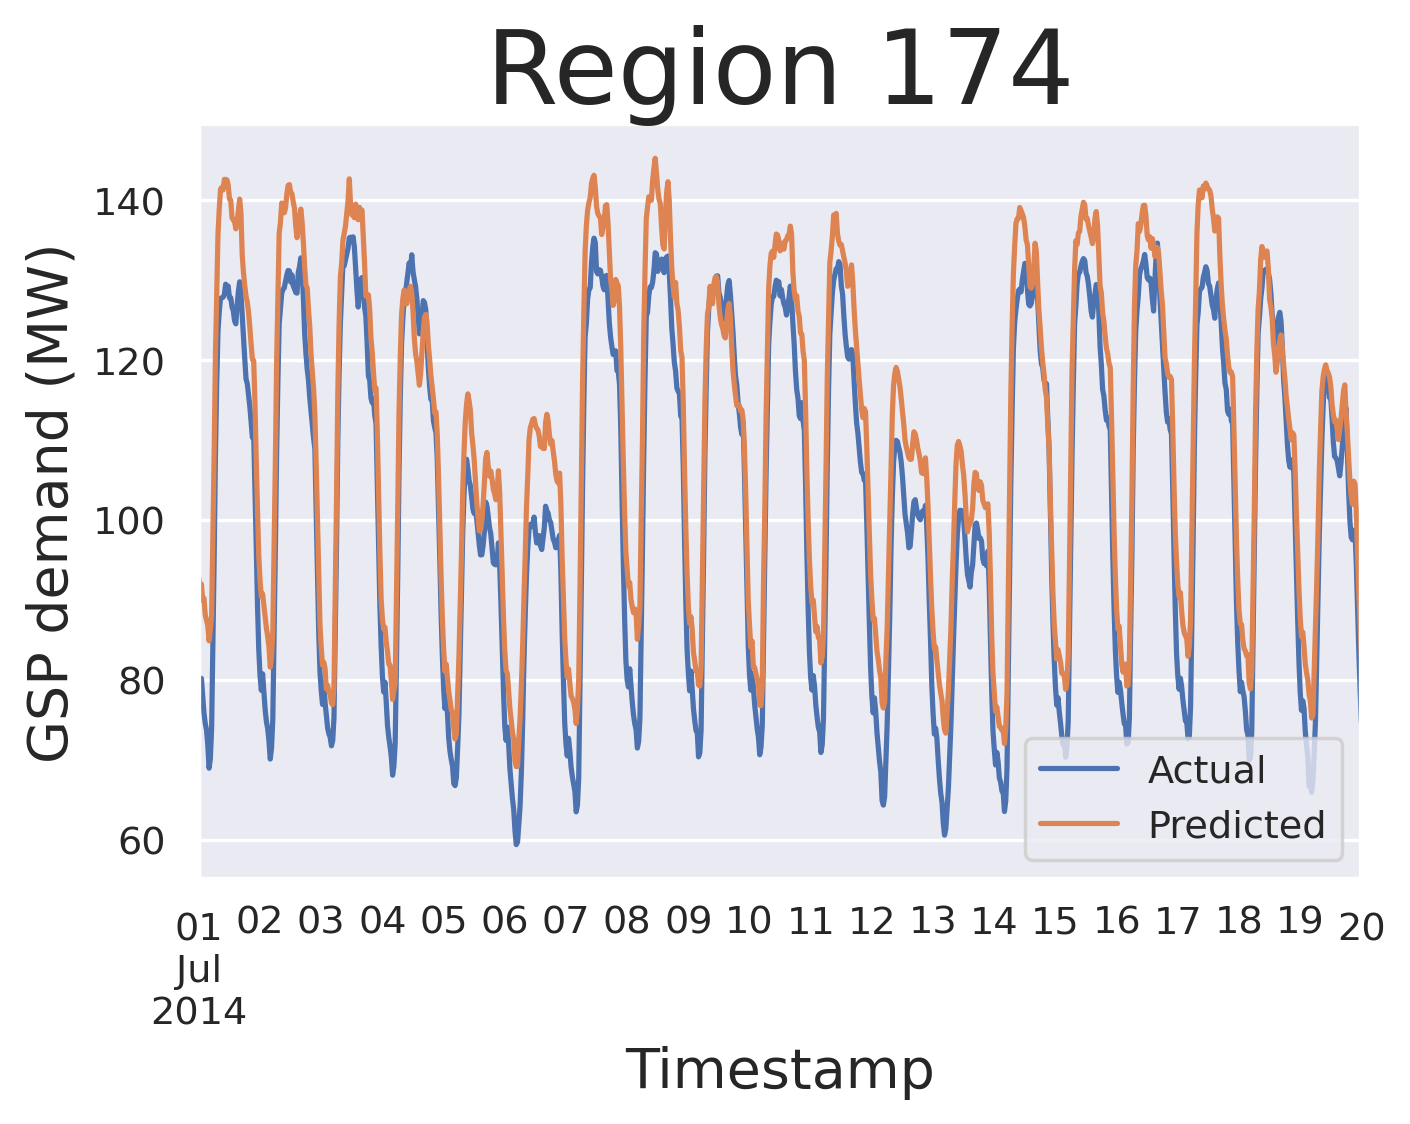

<Figure size 1500x1000 with 0 Axes>

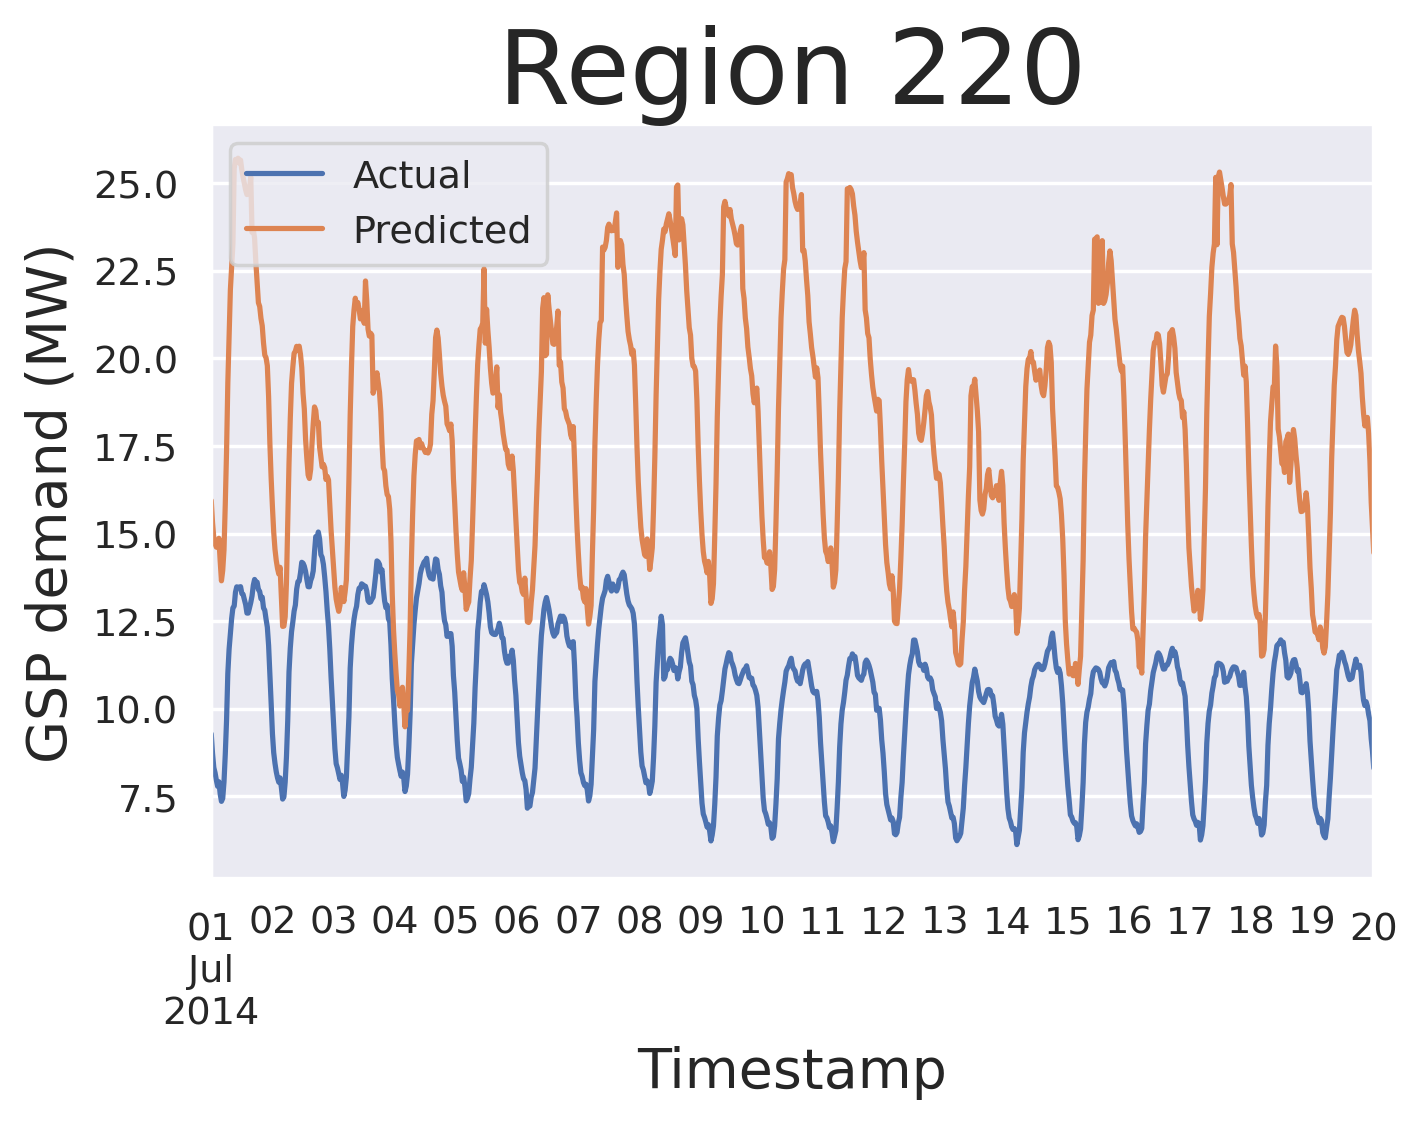

<Figure size 1500x1000 with 0 Axes>

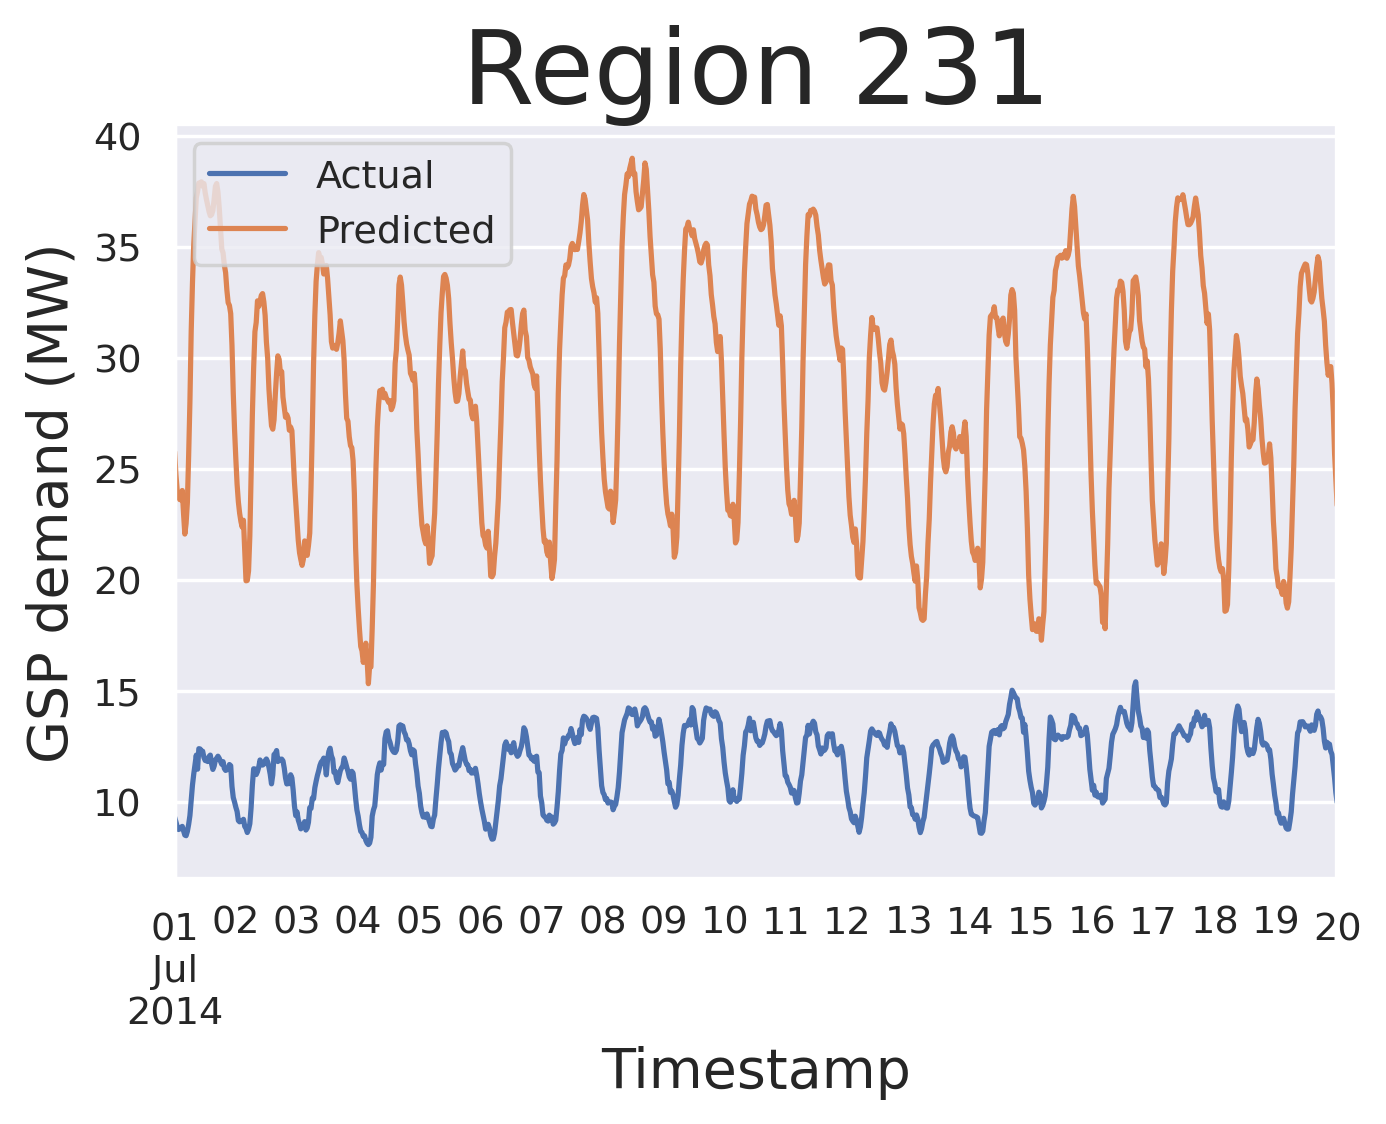

In [36]:
# validation.plot_timeseries(pes_gsp_data, start="2021-05-01", end="2021-05-20", n_gsps=10)
validation.plot_timeseries(pes_gsp_data, start="2014-07-01", end="2014-07-20", n_gsps=13)

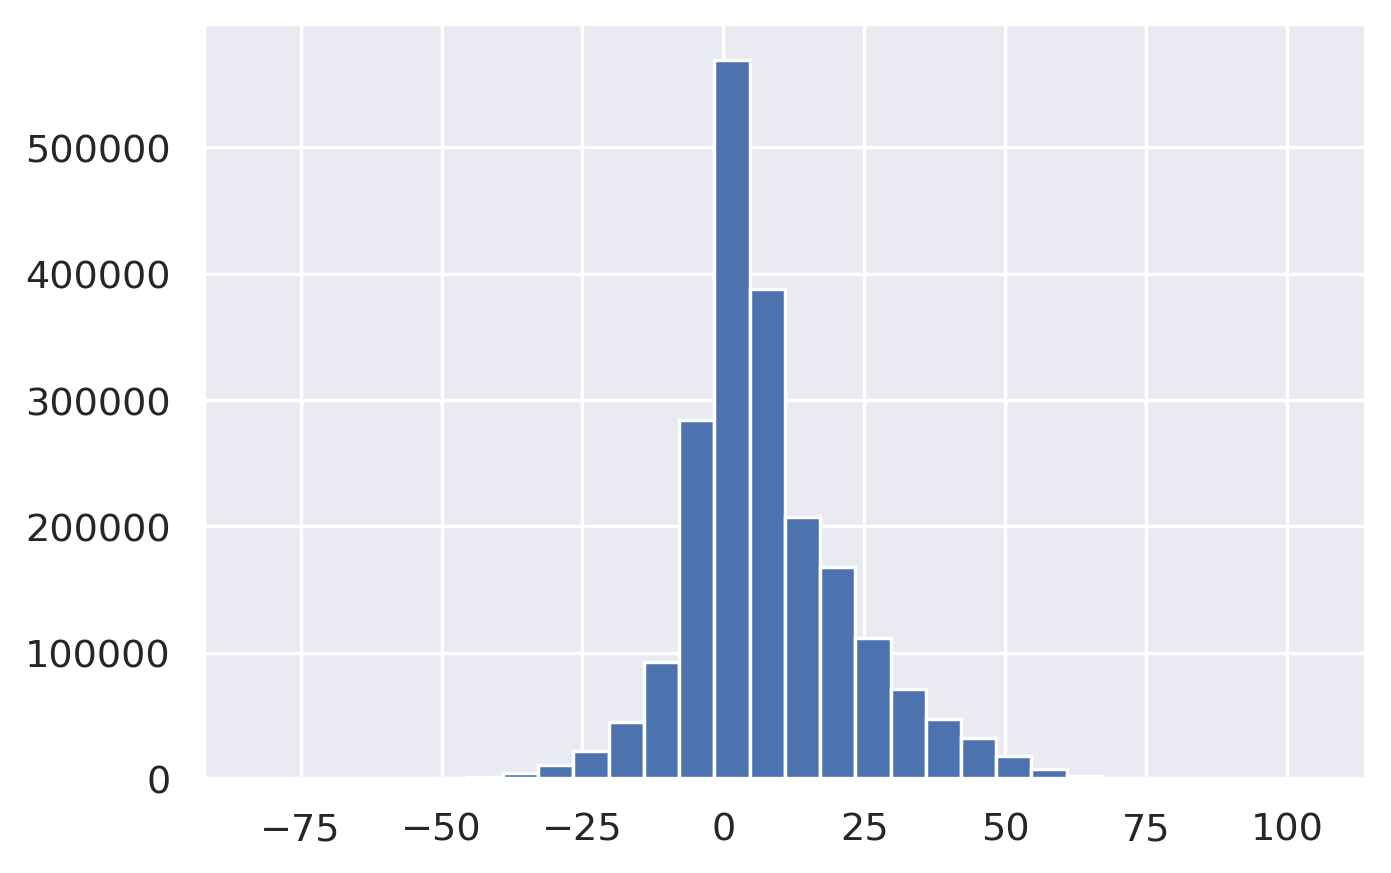

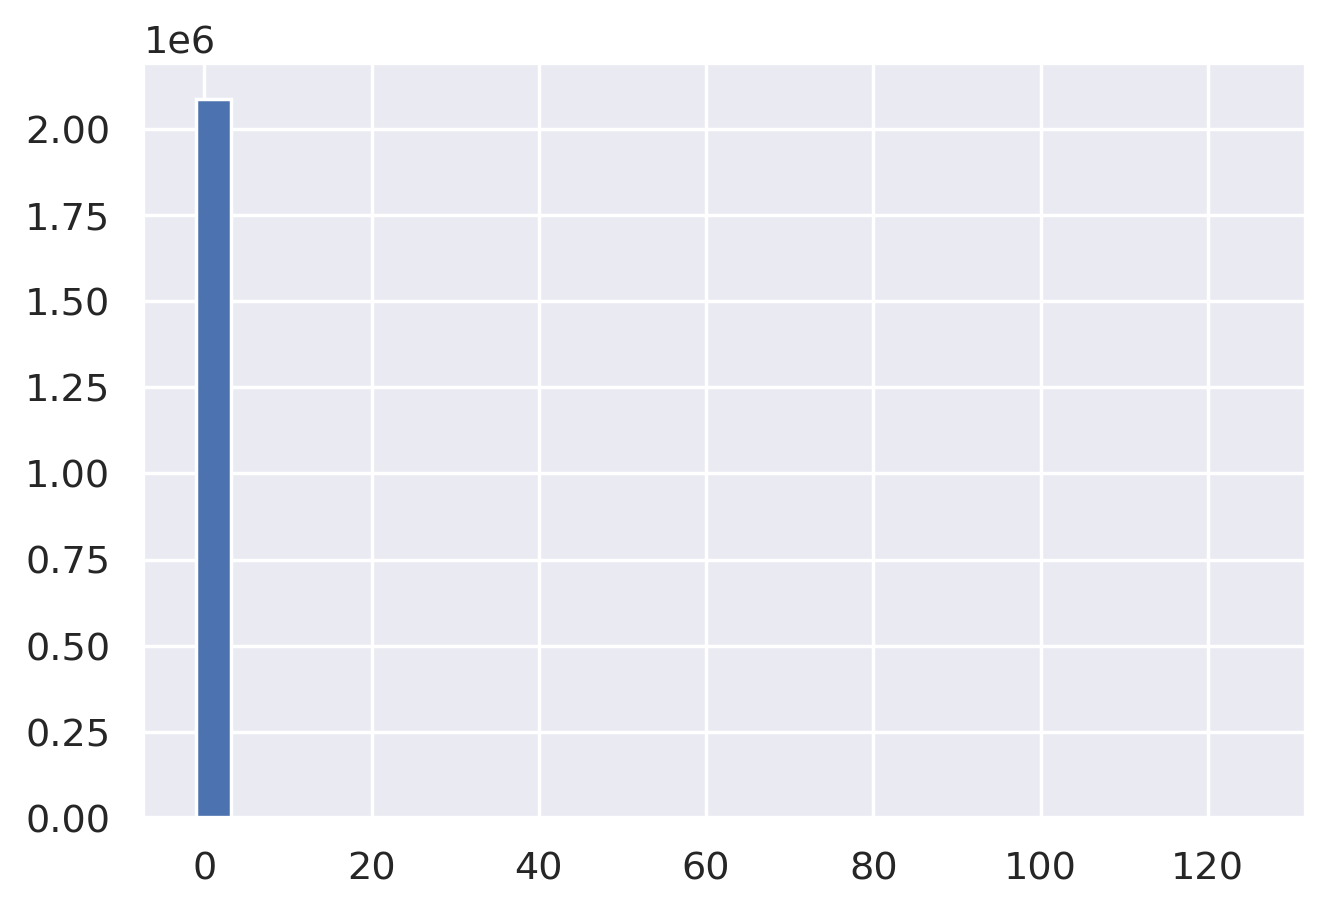

In [37]:
validation.histogram_residuals(pes_gsp_data)